# Core Workflow: Applying 3-Category Classifier
  
Date: 2018-12-06  
Author: Taufiq Rashid, Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

#ULU_REPO = os.environ["ULU_REPO"]
#sys.path.append(ULU_REPO+'/utils')
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_keras

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution= 5  # Lx:15 S2:10

ndvi_bands = ['raw'];


tile_resolution = resolution
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

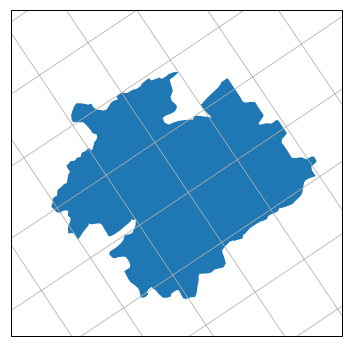

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 1687
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.15379176547472, 17.552665220579843], [78.16734375580529, 17.552859679408396], [78.16714143788593, 17.565859911723514], [78.15358848280565, 17.56566529977946], [78.15379176547472, 17.552665220579843]]]}


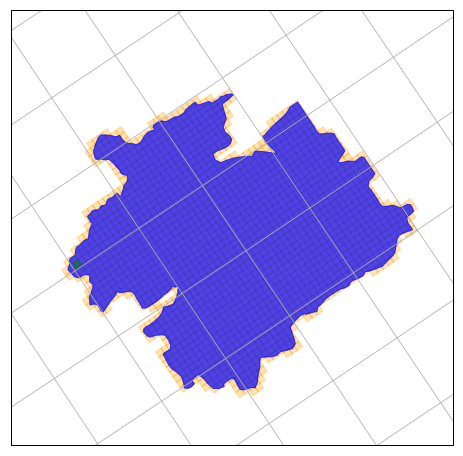

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 17    # width of square window

bands_vir=bands[:-1]
bands_sar=None
bands_ndvi=ndvi_bands
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix = 'AC'

model_id = '3cat_Hyd_P-U'
unflatten_input = True # is the model a cnn?
n_cats = 3 # number of categories

water_overwrite = False
water_mask = False

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+ndvi 7


### Use model to generate performance statistics

Assign application-specific variables

In [7]:
cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 4
cats_map[3] = 4
cats_map[4] = 4
cats_map[5] = 4
cats_map[6] = 6

categories = [0,1,4,6]

notes = 'application of 3cat_Hyd_P-U to an outsample image and an insample city'

Load the samples of interest. Just as when training a model, this dataset can be constructed from one or more images of one or more cities.

In [8]:
place_images = {}
place_images[place] = ['V']

X_train_raw, Y_train_raw, X_valid_raw, Y_valid_raw = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window, resolution=resolution)

calculate total size of training and validation supersets
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_V.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_V.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
223806 95918
construct np arrays for supersets
populate superset np arrays
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_V.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_V.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
(223806, 2023) (223806,)


Prepare data for model ingestion. This process is contingent on what model is being applied and what taxonomy that model employs.

In [9]:
X_train_raw_scaled, X_valid_raw_scaled, scaler = util_ml.scale_learning_data(X_train_raw, X_valid_raw)
print X_train_raw_scaled.shape,  X_valid_raw_scaled.shape

(223806, 2023) (95918, 2023)
(223806, 2023) (95918, 2023)


In [10]:
del X_train_raw, X_valid_raw

In [11]:
# Don't run this if using DNN
X_train = X_train_raw_scaled.reshape((X_train_raw_scaled.shape[0],feature_count,window,window))
X_valid = X_valid_raw_scaled.reshape((X_valid_raw_scaled.shape[0],feature_count,window,window))

In [12]:
del X_train_raw_scaled, X_valid_raw_scaled

In [13]:
print X_train.shape

(223806, 7, 17, 17)


In [14]:
Y_train = Y_train_raw.copy()
Y_valid = Y_valid_raw.copy()

for k, v in cats_map.items():
    Y_train[Y_train_raw==k] = v
    Y_valid[Y_valid_raw==k] = v
    
print Y_train_raw.shape
print Y_train.shape

(223806,)
(223806,)


In [15]:
del Y_train_raw, Y_valid_raw

In [16]:
non_roads = np.where(Y_train!=6)
Y_train = Y_train[non_roads]
X_train = X_train[non_roads]
non_roads = np.where(Y_valid!=6)
Y_valid = Y_valid[non_roads]
X_valid = X_valid[non_roads]

In [17]:
Y_t = Y_train.copy()
Y_v = Y_valid.copy()

Y_t[Y_train==0] = 0
Y_t[Y_train==1] = 1
Y_t[Y_train==4] = 2
Y_t[Y_train==6] = 3

Y_v[Y_valid==0] = 0
Y_v[Y_valid==1] = 1
Y_v[Y_valid==4] = 2
Y_v[Y_valid==6] = 3

In [18]:
categories_reduced = [0,1,2]

# Y_t_cat = to_categorical(Y_t)
# Y_v_cat = to_categorical(Y_v)

### Load model objects

In [22]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

with open(scaler_filename, "rb") as f:
    scaler = pickle.load(f)
f.close()

network = load_model(network_filename, custom_objects={'loss': loss})

In [ ]:
print "evaluate training"
Yhat_t_prob = network.predict(X_train)
Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t,categories_reduced)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)

# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = train_f_score[0] 
train_f_score_nonres = train_f_score[1]  
train_f_score_res = train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)


print "evaluate validation"
Yhat_v_prob = network.predict(X_valid)
Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v,categories_reduced)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = valid_f_score[0] 
valid_f_score_nonres = valid_f_score[1] 
valid_f_score_res = valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],train_recalls[1],train_recalls[2],None]
valid_recalls_expanded = [valid_recalls[0],valid_recalls[1],valid_recalls[2],None]
train_precisions_expanded = [train_precisions[0],train_precisions[1],train_precisions[2],None]
valid_precisions_expanded = [valid_precisions[0],valid_precisions[1],valid_precisions[2],None]

util_workflow.record_model_application(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, window, cats_map, 
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)

evaluate training
0 61798
1 48976
2 81655
[[59320  1389  1089]
 [  857 47428   691]
 [  848  1034 79773]]
192429 186521 0.9692977669685963
evaluate validation
0 26305
1 21132
2 35082
[[24747   839   719]
 [  619 20102   411]
 [  529   579 33974]]
82519 78823 0.9552103152001358


### Use model to generate comprehensive LULC raster

In [ ]:
reload(util_workflow)

util_workflow.classify_tiles(data_path, place, tiles, image_suffix,
        window, stack_label, feature_count, model_id, scaler, network, n_cats,
        bands_vir=bands_vir,
        bands_sar=bands_sar, bands_ndvi=bands_ndvi, bands_ndbi=bands_ndbi, bands_osm=None,
        haze_removal=False, unflatten_input=unflatten_input, water_overwrite=water_overwrite, water_mask=water_mask)

Feature count: 7
Stack label:  vir+ndvi
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [195280.0, 1934000.0, 196720.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-238:1511', u'ti': -238, u'tj': 1511, u'geotrans': [195280.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]'}
tile 0 load VIR im

.....................done
0 11934
1 53500
2 102
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0004_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 4 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [196560.0, 1932720.0, 198000.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-237:1510', u'ti': -237, u'tj': 1510, u'geotrans': [196560.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 24373
1 41154
2 9
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0009_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.8172583e-05 9.9990177e-01 1.7145967e-15 1.0000000e+00 9.9990177e-01]
tile 9 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [196560.0, 1941680.0, 198000.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-237:1517', u'ti': -237, u'tj': 1517, u'geotrans': [196560.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 58246
1 6737
2 553
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0014_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 8.613128e-12 8.598965e-15 0.000000e+00 1.000000e+00]
tile 14 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [197840.0, 1934000.0, 199280.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-236:1511', u'ti': -236, u'tj': 1511, u'geotrans': [197840.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

.....................done
0 5434
1 59520
2 582
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0019_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 19 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [197840.0, 1940400.0, 199280.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-236:1516', u'ti': -236, u'tj': 1516, u'geotrans': [197840.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 44599
1 20928
2 9
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0024_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.4345413e-12 5.7989800e-09 0.0000000e+00 1.0000000e+00]
tile 24 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [199120.0, 1934000.0, 200560.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-235:1511', u'ti': -235, u'tj': 1511, u'geotrans': [199120.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 47203
1 12740
2 5593
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0029_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.0024367  0.9746113  0.02295199 1.         0.9746113 ]
tile 29 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [199120.0, 1940400.0, 200560.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-235:1516', u'ti': -235, u'tj': 1516, u'geotrans': [199120.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_e

.....................done
0 27263
1 38273
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0034_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 34 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [200400.0, 1932720.0, 201840.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-234:1510', u'ti': -234, u'tj': 1510, u'geotrans': [200400.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.126 - 0.1662 )
vir band 1 into imn band 1 ( 0.108 - 0.1664 )
vir band 2 into imn band 2 ( 0.0912 - 0.2119 )
vir band 3 into imn band 3 ( 0.1296 - 0.2886 )
vir band 4 into imn band 4 ( 0.1114 - 0.3504 )
vir band 5 into imn band 5 ( 0.0586 - 0.2612 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.055577528 - 0.43123052 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65359
1 171
2 6
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0039_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.9198494e-10 3.2393650e-14 0.0000000e+00 1.0000000e+00]
tile 39 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [200400.0, 1939120.0, 201840.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-234:1515', u'ti': -234, u'tj': 1515, u'geotrans': [200400.0

.....................done
0 58311
1 7087
2 138
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0044_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.1361348e-09 6.3317853e-09 0.0000000e+00 1.0000000e+00]
tile 44 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [200400.0, 1945520.0, 201840.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-234:1520', u'ti': -234, u'tj': 1520, u'geotrans': [200400.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 8359
1 57177
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0049_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 49 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1913520.0, 203120.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1495', u'ti': -233, u'tj': 1495, u'geotrans': [201680.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["

.....................done
0 12272
1 53261
2 3
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0054_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 54 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1922480.0, 203120.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1502', u'ti': -233, u'tj': 1502, u'geotrans': [201680.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 64578
1 932
2 26
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0059_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999988e-01 1.2507574e-07 3.1013183e-13 0.0000000e+00 9.9999988e-01]
tile 59 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1936560.0, 203120.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1513', u'ti': -233, u'tj': 1513, u'geotrans': [201680.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 58556
1 4801
2 2179
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0064_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.0175028e-09 2.5009221e-09 0.0000000e+00 1.0000000e+00]
tile 64 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [201680.0, 1942960.0, 203120.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-233:1518', u'ti': -233, u'tj': 1518, u'geotrans': [201680.0, 5.0, 0, 1944400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 59986
1 5505
2 45
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0069_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.9305077e-11 9.2682942e-25 0.0000000e+00 1.0000000e+00]
tile 69 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1909680.0, 204400.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1492', u'ti': -232, u'tj': 1492, u'geotrans': [202960.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1179 - 0.1885 )
vir band 1 into imn band 1 ( 0.1034 - 0.1936 )
vir band 2 into imn band 2 ( 0.086 - 0.2309 )
vir band 3 into imn band 3 ( 0.1081 - 0.4034 )
vir band 4 into imn band 4 ( 0.1346 - 0.3678 )
vir band 5 into imn band 5 ( 0.0755 - 0.2695 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.022801204 - 0.58081096 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63158
1 2346
2 32
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0074_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.2163328e-12 9.4647349e-17 0.0000000e+00 1.0000000e+00]
tile 74 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1916080.0, 204400.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1497', u'ti': -232, u'tj': 

.....................done
0 29211
1 36325
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0079_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 79 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1931440.0, 204400.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1509', u'ti': -232, u'tj': 1509, u'geotrans': [202960.0, 5.0, 0, 1932880.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

.....................done
0 61911
1 3386
2 239
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0084_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.0511215e-13 7.0455153e-10 0.0000000e+00 1.0000000e+00]
tile 84 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1937840.0, 204400.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1514', u'ti': -232, u'tj': 1514, u'geotrans': [202960.0, 5.0, 0, 1939280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 61191
1 4212
2 133
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0089_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.3023945e-08 3.2350662e-15 0.0000000e+00 1.0000000e+00]
tile 89 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [202960.0, 1944240.0, 204400.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-232:1519', u'ti': -232, u'tj': 1519, u'geotrans': [202960.0, 5.0, 0, 1945680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 62894
1 2563
2 79
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0094_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.3776470e-13 2.8079714e-09 0.0000000e+00 1.0000000e+00]
tile 94 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1910960.0, 205680.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1493', u'ti': -231, u'tj': 1493, u'geotrans': [204240.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 61038
1 4478
2 20
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0099_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9923229e-01 7.6771446e-04 5.7357235e-12 0.0000000e+00 9.9923229e-01]
tile 99 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1917360.0, 205680.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1498', u'ti': -231, u'tj': 1498, u'geotrans': [204240.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 64898
1 615
2 23
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0104_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.2372639e-11 1.1055253e-19 0.0000000e+00 1.0000000e+00]
tile 104 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1923760.0, 205680.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1503', u'ti': -231, u'tj': 1503, u'geotrans': [204240.0, 5.0, 0, 1925200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 43521
1 21415
2 600
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0109_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.5596651e-08 2.8720434e-14 0.0000000e+00 1.0000000e+00]
tile 109 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1932720.0, 205680.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1510', u'ti': -231, u'tj': 1510, u'geotrans': [204240.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

.....................done
0 62944
1 2534
2 58
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0114_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999917e-01 5.2328409e-07 3.2302552e-07 0.0000000e+00 9.9999917e-01]
tile 114 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1939120.0, 205680.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1515', u'ti': -231, u'tj': 1515, u'geotrans': [204240.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 64036
1 1500
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0119_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.1191748e-10 1.3317855e-10 0.0000000e+00 1.0000000e+00]
tile 119 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [204240.0, 1945520.0, 205680.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-231:1520', u'ti': -231, u'tj': 1520, u'geotrans': [204240.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

.....................done
0 1804
1 63732
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0124_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 124 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1908400.0, 206960.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1491', u'ti': -230, u'tj': 1491, u'geotrans': [205520.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1176 - 0.1898 )
vir band 1 into imn band 1 ( 0.0988 - 0.1933 )
vir band 2 into imn band 2 ( 0.0875 - 0.2384 )
vir band 3 into imn band 3 ( 0.1019 - 0.4301 )
vir band 4 into imn band 4 ( 0.1303 - 0.3972 )
vir band 5 into imn band 5 ( 0.0871 - 0.3045 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.05838485 - 0.6387871 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63889
1 1641
2 6
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0129_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999988e-01 7.4732021e-08 1.1638699e-11 0.0000000e+00 9.9999988e-01]
tile 129 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1914800.0, 206960.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1496', u'ti': -230, u'tj': 

.....................done
0 65253
1 283
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0134_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.00000000e+00 1.24667326e-14 1.04407010e-12 0.00000000e+00
 1.00000000e+00]
tile 134 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1921200.0, 206960.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1501', u'ti': -230, u'tj': 1501, u'geotrans': [205520.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

tile 139 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0139_vir_AC_5m.tif
vir shape: (7, 288, 288)
77656 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1867 )
vir band 1 into imn band 1 ( 0.0 - 0.189 )
vir band 2 into imn band 2 ( 0.0 - 0.223 )
vir band 3 into imn band 3 ( 0.0 - 0.342 )
vir band 4 into imn band 4 ( 0.0 - 0.4035 )
vir band 5 into imn band 5 ( 0.0 - 0.3204 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.5517229 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64760
1 766
2 10
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0139_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999976e-01 2.0862909e-07 1.1167083e-08 0.0000000e+00 9.9999976e-01]
tile 139 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1928880.0, 206960.0, 1930320.0], u'pad': 16, u'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1276 - 0.1795 )
vir band 1 into imn band 1 ( 0.1122 - 0.1819 )
vir band 2 into imn band 2 ( 0.0936 - 0.2146 )
vir band 3 into imn band 3 ( 0.1413 - 0.3283 )
vir band 4 into imn band 4 ( 0.0891 - 0.3684 )
vir band 5 into imn band 5 ( 0.0504 - 0.2901 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.053899232 - 0.49567083 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62734
1 1820
2 982
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0144_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9973410e-01 1.8156909e-04 8.4268300e-05 0.0000000e+00 9.9973410e-01]
tile 144 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1935280.0, 206960.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1512', u'ti': -230, u'tj

.....................done
0 47981
1 13503
2 4052
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0149_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.2177593e-08 1.0810898e-13 0.0000000e+00 1.0000000e+00]
tile 149 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1941680.0, 206960.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1517', u'ti': -230, u'tj': 1517, u'geotrans': [205520.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

.....................done
0 63912
1 1623
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0154_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.5897168e-27 2.1255516e-24 0.0000000e+00 1.0000000e+00]
tile 154 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [205520.0, 1948080.0, 206960.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-230:1522', u'ti': -230, u'tj': 1522, u'geotrans': [205520.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 56294
1 9117
2 125
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0159_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.5220192e-12 1.3074560e-12 0.0000000e+00 1.0000000e+00]
tile 159 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1907120.0, 208240.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1490', u'ti': -229, u'tj': 1490, u'geotrans': [206800.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 64499
1 959
2 78
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0164_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0839924e-14 4.8285295e-17 0.0000000e+00 1.0000000e+00]
tile 164 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1913520.0, 208240.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1495', u'ti': -229, u'tj': 1495, u'geotrans': [206800.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 63840
1 1643
2 53
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0169_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.9724251e-08 5.0858975e-13 0.0000000e+00 1.0000000e+00]
tile 169 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1919920.0, 208240.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1500', u'ti': -229, u'tj': 1500, u'geotrans': [206800.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

......................done
0 60240
1 5206
2 90
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0181_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999952e-01 5.1358410e-07 1.2758802e-08 0.0000000e+00 9.9999952e-01]
tile 181 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1935280.0, 208240.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1512', u'ti': -229, u'tj': 1512, u'geotrans': [206800.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1325 - 0.2434 )
vir band 1 into imn band 1 ( 0.1143 - 0.2508 )
vir band 2 into imn band 2 ( 0.0974 - 0.2857 )
vir band 3 into imn band 3 ( 0.1078 - 0.32 )
vir band 4 into imn band 4 ( 0.0982 - 0.5422 )
vir band 5 into imn band 5 ( 0.0548 - 0.5494 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.008890938 - 0.44129017 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 47511
1 16639
2 1386
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0186_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.9164301e-09 5.8381799e-16 0.0000000e+00 1.0000000e+00]
tile 186 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1941680.0, 208240.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1517', u'ti': -229, u'tj

.....................done
0 60156
1 5324
2 56
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0191_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.8923957e-01 1.0760472e-02 5.1928437e-11 0.0000000e+00 9.8923957e-01]
tile 191 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [206800.0, 1948080.0, 208240.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-229:1522', u'ti': -229, u'tj': 1522, u'geotrans': [206800.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

nz 65536
.....................done
0 65408
1 100
2 28
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0196_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9996912e-01 2.9894856e-05 9.2438802e-07 0.0000000e+00 9.9996912e-01]
tile 196 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1907120.0, 209520.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1490', u'ti': -228, u'tj': 1490, u'geotrans': [208080.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.999

.....................done
0 64945
1 556
2 35
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0201_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.3364704e-21 6.8233906e-23 0.0000000e+00 1.0000000e+00]
tile 201 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1913520.0, 209520.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1495', u'ti': -228, u'tj': 1495, u'geotrans': [208080.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 64441
1 1080
2 15
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0206_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.8558202e-10 3.7752353e-11 0.0000000e+00 1.0000000e+00]
tile 206 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1919920.0, 209520.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1500', u'ti': -228, u'tj': 1500, u'geotrans': [208080.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 22799
1 42735
2 2
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0211_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 211 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1927600.0, 209520.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1506', u'ti': -228, u'tj': 1506, u'geotrans': [208080.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 65534
1 2
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0216_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999952e-01 5.0588847e-07 9.9479056e-09 0.0000000e+00 9.9999952e-01]
tile 216 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1934000.0, 209520.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1511', u'ti': -228, u'tj': 1511, u'geotrans': [208080.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["fa

.....................done
0 49203
1 8152
2 8181
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0221_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 5.9704276e-13 4.5304832e-10 0.0000000e+00 1.0000000e+00]
tile 221 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1940400.0, 209520.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1516', u'ti': -228, u'tj': 1516, u'geotrans': [208080.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1208 - 0.1826 )
vir band 1 into imn band 1 ( 0.1057 - 0.1877 )
vir band 2 into imn band 2 ( 0.0878 - 0.2207 )
vir band 3 into imn band 3 ( 0.0758 - 0.3598 )
vir band 4 into imn band 4 ( 0.0344 - 0.3652 )
vir band 5 into imn band 5 ( 0.0206 - 0.2942 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14582118 - 0.56638974 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58376
1 7075
2 85
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0226_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [3.4680462e-04 9.9965322e-01 1.1802706e-25 1.0000000e+00 9.9965322e-01]
tile 226 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [208080.0, 1946800.0, 209520.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-228:1521', u'ti': -228, u'tj'

.....................done
0 39319
1 26217
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0231_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0562121e-12 3.5263146e-16 0.0000000e+00 1.0000000e+00]
tile 231 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1905840.0, 210800.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1489', u'ti': -227, u'tj': 1489, u'geotrans': [209360.0, 5.0, 0, 1907280.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

.....................done
0 65347
1 186
2 3
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0236_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.5308430e-28 1.7715595e-32 0.0000000e+00 1.0000000e+00]
tile 236 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1912240.0, 210800.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1494', u'ti': -227, u'tj': 1494, u'geotrans': [209360.0, 5.0, 0, 1913680.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 61781
1 2896
2 859
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0241_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9822086e-01 6.1826024e-04 1.1608582e-03 0.0000000e+00 9.9822086e-01]
tile 241 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1918640.0, 210800.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1499', u'ti': -227, u'tj': 1499, u'geotrans': [209360.0, 5.0, 0, 1920080.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 64258
1 1276
2 2
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0246_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999595e-01 4.0007380e-06 2.5537767e-13 0.0000000e+00 9.9999595e-01]
tile 246 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1925040.0, 210800.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1504', u'ti': -227, u'tj': 1504, u'geotrans': [209360.0, 5.0, 0, 1926480.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1262 - 0.2195 )
vir band 1 into imn band 1 ( 0.1069 - 0.2281 )
vir band 2 into imn band 2 ( 0.0913 - 0.2717 )
vir band 3 into imn band 3 ( 0.1048 - 0.3986 )
vir band 4 into imn band 4 ( 0.0829 - 0.389 )
vir band 5 into imn band 5 ( 0.0465 - 0.3319 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.024975892 - 0.6114805 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64269
1 1182
2 85
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0251_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9738723e-01 2.1237782e-05 2.5915254e-03 0.0000000e+00 9.9738723e-01]
tile 251 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1932720.0, 210800.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1510', u'ti': -227, u'tj': 

.....................done
0 59783
1 4719
2 1034
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0256_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 7.7801771e-10 2.4557236e-09 0.0000000e+00 1.0000000e+00]
tile 256 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1939120.0, 210800.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1515', u'ti': -227, u'tj': 1515, u'geotrans': [209360.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

.....................done
0 56160
1 8119
2 1257
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0261_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9986899e-01 1.3095560e-04 2.8129463e-10 0.0000000e+00 9.9986899e-01]
tile 261 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [209360.0, 1945520.0, 210800.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-227:1520', u'ti': -227, u'tj': 1520, u'geotrans': [209360.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

vir shape: (7, 288, 288)
10347 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1595 )
vir band 1 into imn band 1 ( 0.0 - 0.1617 )
vir band 2 into imn band 2 ( 0.0 - 0.2079 )
vir band 3 into imn band 3 ( 0.0 - 0.342 )
vir band 4 into imn band 4 ( 0.0 - 0.4229 )
vir band 5 into imn band 5 ( 0.0 - 0.3107 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.61300075 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 3858
1 61678
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0266_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 266 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1900720.0, 212080.0, 1902160.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1485', u'ti': -226, u'tj': 1485, u'geotrans': [210640.0, 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1208 - 0.1748 )
vir band 1 into imn band 1 ( 0.1068 - 0.1744 )
vir band 2 into imn band 2 ( 0.0858 - 0.2151 )
vir band 3 into imn band 3 ( 0.0982 - 0.3562 )
vir band 4 into imn band 4 ( 0.0468 - 0.4157 )
vir band 5 into imn band 5 ( 0.0262 - 0.3361 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13499284 - 0.5935865 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64677
1 858
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0271_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.5014288e-12 5.2735715e-12 0.0000000e+00 1.0000000e+00]
tile 271 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1907120.0, 212080.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1490', u'ti': -226, u'tj': 1

.....................done
0 65189
1 178
2 169
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0276_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.9631596e-11 2.5583138e-11 0.0000000e+00 1.0000000e+00]
tile 276 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1913520.0, 212080.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1495', u'ti': -226, u'tj': 1495, u'geotrans': [210640.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 63856
1 1637
2 43
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0281_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.3969774e-11 2.0167108e-18 0.0000000e+00 1.0000000e+00]
tile 281 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1919920.0, 212080.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1500', u'ti': -226, u'tj': 1500, u'geotrans': [210640.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 32800
1 32650
2 86
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0286_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 286 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1927600.0, 212080.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1506', u'ti': -226, u'tj': 1506, u'geotrans': [210640.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 52581
1 7188
2 5767
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0291_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.3460156e-09 3.2298249e-08 0.0000000e+00 1.0000000e+00]
tile 291 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1934000.0, 212080.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1511', u'ti': -226, u'tj': 1511, u'geotrans': [210640.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1364 - 0.1948 )
vir band 1 into imn band 1 ( 0.1175 - 0.1916 )
vir band 2 into imn band 2 ( 0.1001 - 0.2171 )
vir band 3 into imn band 3 ( 0.1031 - 0.3402 )
vir band 4 into imn band 4 ( 0.0695 - 0.3408 )
vir band 5 into imn band 5 ( 0.0419 - 0.2855 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.003252044 - 0.52039325 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 22738
1 19999
2 22799
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0296_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.02387194 0.41922632 0.5569017  2.         0.5569017 ]
tile 296 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1940400.0, 212080.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1516', u'ti': -226, u'tj': 1516, u'geotrans': [210640.0, 5.0

vir band 3 into imn band 3 ( 0.0846 - 0.3116 )
vir band 4 into imn band 4 ( 0.0607 - 0.419 )
vir band 5 into imn band 5 ( 0.0422 - 0.3517 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.20600559 - 0.4209006 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62604
1 2896
2 36
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0301_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 4.201410e-09 4.274322e-11 0.000000e+00 1.000000e+00]
tile 301 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [210640.0, 1946800.0, 212080.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-226:1521', u'ti': -226, u'tj': 1521, u'geotrans': [210640.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY

.....................done
0 24407
1 41129
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0306_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9941766e-01 5.8232527e-04 2.6106902e-23 0.0000000e+00 9.9941766e-01]
tile 306 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1902000.0, 213360.0, 1903440.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1486', u'ti': -225, u'tj': 1486, u'geotrans': [211920.0, 5.0, 0, 1903440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

.....................done
0 62943
1 2545
2 48
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0311_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.9799928e-09 5.6928807e-14 0.0000000e+00 1.0000000e+00]
tile 311 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1908400.0, 213360.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1491', u'ti': -225, u'tj': 1491, u'geotrans': [211920.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 65221
1 289
2 26
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0316_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.0239347e-13 1.1129288e-14 0.0000000e+00 1.0000000e+00]
tile 316 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1914800.0, 213360.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1496', u'ti': -225, u'tj': 1496, u'geotrans': [211920.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 60387
1 4942
2 207
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0321_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.7300998e-26 0.0000000e+00 0.0000000e+00 1.0000000e+00]
tile 321 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1921200.0, 213360.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1501', u'ti': -225, u'tj': 1501, u'geotrans': [211920.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 23267
1 42055
2 214
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0326_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 326 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1927600.0, 213360.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1506', u'ti': -225, u'tj': 1506, u'geotrans': [211920.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

tile 331 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0331_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1252 - 0.1937 )
vir band 1 into imn band 1 ( 0.109 - 0.2029 )
vir band 2 into imn band 2 ( 0.0935 - 0.2508 )
vir band 3 into imn band 3 ( 0.0994 - 0.3374 )
vir band 4 into imn band 4 ( 0.1116 - 0.4147 )
vir band 5 into imn band 5 ( 0.0641 - 0.3496 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.010217642 - 0.47348723 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62172
1 1346
2 2018
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0331_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.2713564e-10 5.9488731e-10 0.0000000e+00 1.0000000e+00]
tile 331 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1934000.0, 213

.....................done
0 39479
1 11130
2 14927
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0336_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.2952484e-07 3.5868972e-09 9.9999988e-01 2.0000000e+00 9.9999988e-01]
tile 336 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1940400.0, 213360.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1516', u'ti': -225, u'tj': 1516, u'geotrans': [211920.0, 5.0, 0, 1941840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],P

.....................done
0 58313
1 7219
2 4
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0341_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999738e-01 2.6561991e-06 3.9386053e-10 0.0000000e+00 9.9999738e-01]
tile 341 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [211920.0, 1946800.0, 213360.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-225:1521', u'ti': -225, u'tj': 1521, u'geotrans': [211920.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 627
1 64909
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0346_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 346 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1900720.0, 214640.0, 1902160.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1485', u'ti': -224, u'tj': 1485, u'geotrans': [213200.0, 5.0, 0, 1902160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["

.....................done
0 65233
1 299
2 4
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0351_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 8.219453e-09 1.578083e-08 0.000000e+00 1.000000e+00]
tile 351 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1907120.0, 214640.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1490', u'ti': -224, u'tj': 1490, u'geotrans': [213200.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["f

.....................done
0 63189
1 2210
2 137
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0356_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.1579057e-09 6.8555690e-09 0.0000000e+00 1.0000000e+00]
tile 356 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1913520.0, 214640.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1495', u'ti': -224, u'tj': 1495, u'geotrans': [213200.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 61605
1 3135
2 796
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0361_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9996960e-01 5.2153018e-06 2.5184905e-05 0.0000000e+00 9.9996960e-01]
tile 361 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1919920.0, 214640.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1500', u'ti': -224, u'tj': 1500, u'geotrans': [213200.0, 5.0, 0, 1921360.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 60762
1 4613
2 161
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0366_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.5048908e-18 2.6186759e-16 0.0000000e+00 1.0000000e+00]
tile 366 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1926320.0, 214640.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1505', u'ti': -224, u'tj': 1505, u'geotrans': [213200.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 53324
1 6239
2 5973
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0371_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9956113e-01 4.2869520e-04 1.0167218e-05 0.0000000e+00 9.9956113e-01]
tile 371 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1932720.0, 214640.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1510', u'ti': -224, u'tj': 1510, u'geotrans': [213200.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

.....................done
0 17108
1 16192
2 32236
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0376_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3827740e-07 1.9228764e-06 9.9999762e-01 2.0000000e+00 9.9999762e-01]
tile 376 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1939120.0, 214640.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1515', u'ti': -224, u'tj': 1515, u'geotrans': [213200.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],P

.....................done
0 56975
1 7935
2 626
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0381_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.2818327e-09 3.7279248e-14 0.0000000e+00 1.0000000e+00]
tile 381 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1945520.0, 214640.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1520', u'ti': -224, u'tj': 1520, u'geotrans': [213200.0, 5.0, 0, 1946960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 12680
1 52856
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0386_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 386 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [213200.0, 1958320.0, 214640.0, 1959760.0], u'pad': 16, u'key': u'256:16:5.0:44:-224:1530', u'ti': -224, u'tj': 1530, u'geotrans': [213200.0, 5.0, 0, 1959760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

vir shape: (7, 288, 288)
54174 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2385 )
vir band 1 into imn band 1 ( 0.0 - 0.2498 )
vir band 2 into imn band 2 ( 0.0 - 0.2905 )
vir band 3 into imn band 3 ( 0.0 - 0.3825 )
vir band 4 into imn band 4 ( 0.0 - 0.4345 )
vir band 5 into imn band 5 ( 0.0 - 0.3895 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.116936974 - 0.5919849 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 45084
1 20252
2 200
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0391_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.00000000e+00 1.06639835e-08 1.42459368e-13 0.00000000e+00
 1.00000000e+00]
tile 391 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1902000.0, 215920.0, 1903440.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1486', u'ti': -223, u'tj': 1486, u'

.....................done
0 65449
1 83
2 4
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0396_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.5942610e-12 1.4489064e-12 0.0000000e+00 1.0000000e+00]
tile 396 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1908400.0, 215920.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1491', u'ti': -223, u'tj': 1491, u'geotrans': [214480.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETE

.....................done
0 65026
1 496
2 14
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0401_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999917e-01 1.8239479e-10 8.3817446e-07 0.0000000e+00 9.9999917e-01]
tile 401 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1914800.0, 215920.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1496', u'ti': -223, u'tj': 1496, u'geotrans': [214480.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAME

.....................done
0 62260
1 3094
2 182
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0406_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 7.5073583e-09 2.2851984e-10 0.0000000e+00 1.0000000e+00]
tile 406 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1921200.0, 215920.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1501', u'ti': -223, u'tj': 1501, u'geotrans': [214480.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir band 1 into imn band 1 ( 0.107 - 0.226 )
vir band 2 into imn band 2 ( 0.0973 - 0.2715 )
vir band 3 into imn band 3 ( 0.1121 - 0.3225 )
vir band 4 into imn band 4 ( 0.0632 - 0.4097 )
vir band 5 into imn band 5 ( 0.034 - 0.4017 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03347264 - 0.48789683 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 54297
1 8413
2 2826
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0411_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999905e-01 5.0169287e-09 9.9351689e-07 0.0000000e+00 9.9999905e-01]
tile 411 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1927600.0, 215920.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1506', u'ti': -223, u'tj': 1506, u'geotrans': [214480.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["

.....................done
0 57161
1 3703
2 4672
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0416_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.4390224e-27 0.0000000e+00 0.0000000e+00 1.0000000e+00]
tile 416 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1934000.0, 215920.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1511', u'ti': -223, u'tj': 1511, u'geotrans': [214480.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1299 - 0.2038 )
vir band 1 into imn band 1 ( 0.1158 - 0.2058 )
vir band 2 into imn band 2 ( 0.094 - 0.2367 )
vir band 3 into imn band 3 ( 0.1132 - 0.3247 )
vir band 4 into imn band 4 ( 0.0516 - 0.3754 )
vir band 5 into imn band 5 ( 0.0341 - 0.3182 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.06786565 - 0.5485865 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 54735
1 7555
2 3246
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0421_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9998152e-01 1.8450157e-05 1.1272766e-08 0.0000000e+00 9.9998152e-01]
tile 421 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1940400.0, 215920.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1516', u'ti': -223, u'tj'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.127 - 0.2241 )
vir band 1 into imn band 1 ( 0.1127 - 0.2347 )
vir band 2 into imn band 2 ( 0.0897 - 0.2869 )
vir band 3 into imn band 3 ( 0.0776 - 0.3997 )
vir band 4 into imn band 4 ( 0.0341 - 0.4365 )
vir band 5 into imn band 5 ( 0.0232 - 0.4025 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13030683 - 0.5878461 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 52168
1 13340
2 28
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0426_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9278814e-01 7.2033633e-03 8.5218917e-06 0.0000000e+00 9.9278814e-01]
tile 426 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1946800.0, 215920.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1521', u'ti': -223, u'tj':

vir shape: (7, 288, 288)
45001 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1501 )
vir band 1 into imn band 1 ( 0.0 - 0.1411 )
vir band 2 into imn band 2 ( 0.0 - 0.1818 )
vir band 3 into imn band 3 ( 0.0 - 0.305 )
vir band 4 into imn band 4 ( 0.0 - 0.3704 )
vir band 5 into imn band 5 ( 0.0 - 0.2707 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.5193979 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 33090
1 32446
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0431_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 8.277800e-18 6.517634e-23 0.000000e+00 1.000000e+00]
tile 431 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [214480.0, 1959600.0, 215920.0, 1961040.0], u'pad': 16, u'key': u'256:16:5.0:44:-223:1531', u'ti': -223, u'tj': 1531, u'geotrans': [214480.0, 5.0, 

vir shape: (7, 288, 288)
51928 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2256 )
vir band 1 into imn band 1 ( 0.0 - 0.2444 )
vir band 2 into imn band 2 ( 0.0 - 0.2966 )
vir band 3 into imn band 3 ( 0.0 - 0.3663 )
vir band 4 into imn band 4 ( 0.0 - 0.4722 )
vir band 5 into imn band 5 ( 0.0 - 0.3969 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.59773636 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 43362
1 22112
2 62
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0436_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999595e-01 4.0670520e-06 2.7489524e-09 0.0000000e+00 9.9999595e-01]
tile 436 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1903280.0, 217200.0, 1904720.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1487', u'ti': -222, u'tj': 1487, u'geotrans': [215

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1246 - 0.1885 )
vir band 1 into imn band 1 ( 0.1087 - 0.1784 )
vir band 2 into imn band 2 ( 0.0915 - 0.2256 )
vir band 3 into imn band 3 ( 0.0968 - 0.3677 )
vir band 4 into imn band 4 ( 0.0556 - 0.4266 )
vir band 5 into imn band 5 ( 0.033 - 0.3404 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.09278307 - 0.5593135 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64322
1 1162
2 52
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0441_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.4672632e-17 4.8938379e-18 0.0000000e+00 1.0000000e+00]
tile 441 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1909680.0, 217200.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1492', u'ti': -222, u'tj': 

/data/phase_iii/hyderabad/hyderabad_tile0446_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1083 - 0.1814 )
vir band 1 into imn band 1 ( 0.0886 - 0.1884 )
vir band 2 into imn band 2 ( 0.07 - 0.2156 )
vir band 3 into imn band 3 ( 0.0551 - 0.3919 )
vir band 4 into imn band 4 ( 0.0244 - 0.3978 )
vir band 5 into imn band 5 ( 0.0132 - 0.3269 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14062403 - 0.64990306 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63000
1 2468
2 68
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0446_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 8.2234180e-17 1.0216882e-10 0.0000000e+00 1.0000000e+00]
tile 446 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1916080.0, 217200.0, 1917520.0], u'pad': 1

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.113 - 0.2575 )
vir band 1 into imn band 1 ( 0.0959 - 0.2685 )
vir band 2 into imn band 2 ( 0.0801 - 0.3165 )
vir band 3 into imn band 3 ( 0.0997 - 0.4044 )
vir band 4 into imn band 4 ( 0.102 - 0.4152 )
vir band 5 into imn band 5 ( 0.0512 - 0.3261 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08788358 - 0.6479356 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64857
1 406
2 273
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0451_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.7370361e-12 4.1031765e-09 0.0000000e+00 1.0000000e+00]
tile 451 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1922480.0, 217200.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1502', u'ti': -222, u'tj': 1

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1248 - 0.2314 )
vir band 1 into imn band 1 ( 0.107 - 0.2442 )
vir band 2 into imn band 2 ( 0.0919 - 0.2869 )
vir band 3 into imn band 3 ( 0.0865 - 0.335 )
vir band 4 into imn band 4 ( 0.052 - 0.495 )
vir band 5 into imn band 5 ( 0.0348 - 0.4971 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.07509024 - 0.48331156 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 46770
1 9017
2 9749
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0456_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999940e-01 6.2670864e-07 1.8802118e-09 0.0000000e+00 9.9999940e-01]
tile 456 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1928880.0, 217200.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1507', u'ti': -222, u'tj': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1231 - 0.2151 )
vir band 1 into imn band 1 ( 0.1065 - 0.2285 )
vir band 2 into imn band 2 ( 0.0843 - 0.2756 )
vir band 3 into imn band 3 ( 0.0764 - 0.3822 )
vir band 4 into imn band 4 ( 0.0326 - 0.4127 )
vir band 5 into imn band 5 ( 0.019 - 0.6549 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08830499 - 0.5748984 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 39513
1 8396
2 17627
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0461_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.1677395e-01 4.8380335e-09 1.8322612e-01 0.0000000e+00 8.1677395e-01]
tile 461 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1935280.0, 217200.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1512', u'ti': -222, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1229 - 0.1909 )
vir band 1 into imn band 1 ( 0.1094 - 0.1872 )
vir band 2 into imn band 2 ( 0.0908 - 0.2158 )
vir band 3 into imn band 3 ( 0.1296 - 0.3108 )
vir band 4 into imn band 4 ( 0.1154 - 0.3372 )
vir band 5 into imn band 5 ( 0.0654 - 0.2787 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0115910955 - 0.5076388 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63785
1 1304
2 447
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0466_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.1465413e-17 2.5601464e-13 0.0000000e+00 1.0000000e+00]
tile 466 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1941680.0, 217200.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1517', u'ti': -222, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1136 - 0.1816 )
vir band 1 into imn band 1 ( 0.1023 - 0.1879 )
vir band 2 into imn band 2 ( 0.0797 - 0.2274 )
vir band 3 into imn band 3 ( 0.1046 - 0.3898 )
vir band 4 into imn band 4 ( 0.0477 - 0.4333 )
vir band 5 into imn band 5 ( 0.0289 - 0.3573 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1010749 - 0.63148946 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57122
1 8361
2 53
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0471_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999845e-01 1.5891856e-06 1.0016450e-09 0.0000000e+00 9.9999845e-01]
tile 471 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1948080.0, 217200.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1522', u'ti': -222, u'tj':

vir shape: (7, 288, 288)
11547 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1398 )
vir band 1 into imn band 1 ( 0.0 - 0.1295 )
vir band 2 into imn band 2 ( 0.0 - 0.1581 )
vir band 3 into imn band 3 ( 0.0 - 0.2189 )
vir band 4 into imn band 4 ( 0.0 - 0.3292 )
vir band 5 into imn band 5 ( 0.0 - 0.2417 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.24089646 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 6157
1 59379
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0476_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 476 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1954480.0, 217200.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1527', u'ti': -222, u'tj': 1527, u'geotrans': [215760.0,

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1144 - 0.1467 )
vir band 1 into imn band 1 ( 0.1008 - 0.1418 )
vir band 2 into imn band 2 ( 0.0921 - 0.1755 )
vir band 3 into imn band 3 ( 0.1343 - 0.255 )
vir band 4 into imn band 4 ( 0.1879 - 0.3589 )
vir band 5 into imn band 5 ( 0.1101 - 0.2539 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.114558026 - 0.37226152 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65536
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0481_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.3987516e-35 0.0000000e+00 0.0000000e+00 1.0000000e+00]
tile 481 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [215760.0, 1960880.0, 217200.0, 1962320.0], u'pad': 16, u'key': u'256:16:5.0:44:-222:1532', u'ti': -222, u'tj': 1532, u'geo

vir shape: (7, 288, 288)
81390 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2296 )
vir band 1 into imn band 1 ( 0.0 - 0.2088 )
vir band 2 into imn band 2 ( 0.0 - 0.2455 )
vir band 3 into imn band 3 ( 0.0 - 0.3799 )
vir band 4 into imn band 4 ( 0.0 - 0.4617 )
vir band 5 into imn band 5 ( 0.0 - 0.3773 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.614135 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64748
1 788
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0486_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.9087716e-18 2.6921021e-22 0.0000000e+00 1.0000000e+00]
tile 486 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1905840.0, 218480.0, 1907280.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1489', u'ti': -221, u'tj': 1489, u'geotrans': [217040.0, 5.

tile 491 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0491_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1188 - 0.179 )
vir band 1 into imn band 1 ( 0.1049 - 0.1798 )
vir band 2 into imn band 2 ( 0.0884 - 0.226 )
vir band 3 into imn band 3 ( 0.0964 - 0.3565 )
vir band 4 into imn band 4 ( 0.056 - 0.416 )
vir band 5 into imn band 5 ( 0.0333 - 0.3443 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.16328648 - 0.5667271 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65029
1 507
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0491_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.6001932e-09 8.2055546e-10 0.0000000e+00 1.0000000e+00]
tile 491 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1912240.0, 218480.0, 191368

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1082 - 0.2157 )
vir band 1 into imn band 1 ( 0.0863 - 0.2362 )
vir band 2 into imn band 2 ( 0.0657 - 0.2912 )
vir band 3 into imn band 3 ( 0.0488 - 0.4198 )
vir band 4 into imn band 4 ( 0.0191 - 0.384 )
vir band 5 into imn band 5 ( 0.0112 - 0.3099 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.15099092 - 0.66056985 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63248
1 2246
2 42
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0496_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999797e-01 3.2729801e-08 2.0806929e-06 0.0000000e+00 9.9999797e-01]
tile 496 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1918640.0, 218480.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1499', u'ti': -221, u'tj':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1289 - 0.2144 )
vir band 1 into imn band 1 ( 0.1111 - 0.229 )
vir band 2 into imn band 2 ( 0.094 - 0.2763 )
vir band 3 into imn band 3 ( 0.0997 - 0.3246 )
vir band 4 into imn band 4 ( 0.0622 - 0.3966 )
vir band 5 into imn band 5 ( 0.0321 - 0.3447 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.072988994 - 0.46940705 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 50933
1 8418
2 6185
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0501_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.8403651e-01 9.7248114e-05 1.5866214e-02 0.0000000e+00 9.8403651e-01]
tile 501 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1925040.0, 218480.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1504', u'ti': -221, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1185 - 0.2195 )
vir band 1 into imn band 1 ( 0.0996 - 0.2333 )
vir band 2 into imn band 2 ( 0.0855 - 0.2782 )
vir band 3 into imn band 3 ( 0.0753 - 0.3319 )
vir band 4 into imn band 4 ( 0.0361 - 0.4385 )
vir band 5 into imn band 5 ( 0.025 - 0.3824 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.092414625 - 0.5465954 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55858
1 4140
2 5538
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0506_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.6257361e-21 2.2410225e-19 0.0000000e+00 1.0000000e+00]
tile 506 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1931440.0, 218480.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1509', u'ti': -221, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1277 - 0.2156 )
vir band 1 into imn band 1 ( 0.1112 - 0.224 )
vir band 2 into imn band 2 ( 0.0924 - 0.2603 )
vir band 3 into imn band 3 ( 0.078 - 0.2987 )
vir band 4 into imn band 4 ( 0.0458 - 0.3717 )
vir band 5 into imn band 5 ( 0.0285 - 0.3124 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.101381905 - 0.48416865 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 46652
1 5378
2 13506
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0511_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.8133366e-21 6.0988726e-18 0.0000000e+00 1.0000000e+00]
tile 511 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1937840.0, 218480.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1514', u'ti': -221, u't

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1204 - 0.2021 )
vir band 1 into imn band 1 ( 0.1032 - 0.2033 )
vir band 2 into imn band 2 ( 0.0815 - 0.2386 )
vir band 3 into imn band 3 ( 0.064 - 0.3048 )
vir band 4 into imn band 4 ( 0.0284 - 0.4053 )
vir band 5 into imn band 5 ( 0.0179 - 0.6201 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1375072 - 0.43206072 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 45771
1 12871
2 6894
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0516_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.0192018e-10 1.2347842e-10 0.0000000e+00 1.0000000e+00]
tile 516 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1944240.0, 218480.0, 1945680.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1519', u'ti': -221, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1146 - 0.1904 )
vir band 1 into imn band 1 ( 0.1015 - 0.194 )
vir band 2 into imn band 2 ( 0.0765 - 0.229 )
vir band 3 into imn band 3 ( 0.1114 - 0.3909 )
vir band 4 into imn band 4 ( 0.0352 - 0.405 )
vir band 5 into imn band 5 ( 0.0204 - 0.3279 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.07442235 - 0.6438284 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62091
1 3439
2 6
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0521_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.3780728e-02 9.1621929e-01 3.9345117e-16 1.0000000e+00 9.1621929e-01]
tile 521 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1950640.0, 218480.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1524', u'ti': -221, u'tj': 152

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1122 - 0.1702 )
vir band 1 into imn band 1 ( 0.1021 - 0.1845 )
vir band 2 into imn band 2 ( 0.0795 - 0.2374 )
vir band 3 into imn band 3 ( 0.111 - 0.311 )
vir band 4 into imn band 4 ( 0.0805 - 0.4347 )
vir band 5 into imn band 5 ( 0.0393 - 0.3432 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1745344 - 0.55418634 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64502
1 1034
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0526_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.8180725e-09 1.1797875e-12 0.0000000e+00 1.0000000e+00]
tile 526 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [217040.0, 1957040.0, 218480.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-221:1529', u'ti': -221, u'tj': 1529, 

vir shape: (7, 288, 288)
65935 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2446 )
vir band 1 into imn band 1 ( 0.0 - 0.27 )
vir band 2 into imn band 2 ( 0.0 - 0.3299 )
vir band 3 into imn band 3 ( 0.0 - 0.3955 )
vir band 4 into imn band 4 ( 0.0 - 0.526 )
vir band 5 into imn band 5 ( 0.0 - 0.4386 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0 - 0.57383925 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 52562
1 12896
2 78
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0531_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.4677339e-12 1.4057734e-15 0.0000000e+00 1.0000000e+00]
tile 531 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1904560.0, 219760.0, 1906000.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1488', u'ti': -220, u'tj': 1488, u'geotrans': [218320

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1157 - 0.1999 )
vir band 1 into imn band 1 ( 0.1024 - 0.2006 )
vir band 2 into imn band 2 ( 0.0874 - 0.2533 )
vir band 3 into imn band 3 ( 0.1323 - 0.3887 )
vir band 4 into imn band 4 ( 0.1573 - 0.4166 )
vir band 5 into imn band 5 ( 0.0817 - 0.3658 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0076796347 - 0.629085 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65193
1 266
2 77
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0536_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.6691043e-11 7.9936138e-09 0.0000000e+00 1.0000000e+00]
tile 536 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1910960.0, 219760.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1493', u'ti': -220, u'tj': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1085 - 0.1407 )
vir band 1 into imn band 1 ( 0.0844 - 0.1321 )
vir band 2 into imn band 2 ( 0.0637 - 0.1464 )
vir band 3 into imn band 3 ( 0.0454 - 0.2434 )
vir band 4 into imn band 4 ( 0.0162 - 0.2735 )
vir band 5 into imn band 5 ( 0.0088 - 0.2248 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.179699 - 0.49435222 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65444
1 92
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0541_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.4201546e-17 0.0000000e+00 0.0000000e+00 1.0000000e+00]
tile 541 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1917360.0, 219760.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1498', u'ti': -220, u'tj': 1498, u

/data/phase_iii/hyderabad/hyderabad_tile0546_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1185 - 0.236 )
vir band 1 into imn band 1 ( 0.1013 - 0.2416 )
vir band 2 into imn band 2 ( 0.087 - 0.2774 )
vir band 3 into imn band 3 ( 0.085 - 0.3796 )
vir band 4 into imn band 4 ( 0.0371 - 0.4288 )
vir band 5 into imn band 5 ( 0.0247 - 0.4419 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.07916628 - 0.56796896 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55354
1 6880
2 3302
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0546_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [5.4148106e-08 7.7563063e-06 9.9999213e-01 2.0000000e+00 9.9999213e-01]
tile 546 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1923760.0, 219760.0, 1925200.0], u'pad': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1234 - 0.2804 )
vir band 1 into imn band 1 ( 0.1034 - 0.3202 )
vir band 2 into imn band 2 ( 0.0878 - 0.3989 )
vir band 3 into imn band 3 ( 0.0775 - 0.4616 )
vir band 4 into imn band 4 ( 0.0485 - 0.5059 )
vir band 5 into imn band 5 ( 0.0284 - 0.4557 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.07065825 - 0.52994597 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 43950
1 14653
2 6933
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0551_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.1695614e-02 9.0830427e-01 9.2149151e-08 1.0000000e+00 9.0830427e-01]
tile 551 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1930160.0, 219760.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1508', u'ti': -220, u'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1291 - 0.2325 )
vir band 1 into imn band 1 ( 0.1088 - 0.2453 )
vir band 2 into imn band 2 ( 0.0919 - 0.2649 )
vir band 3 into imn band 3 ( 0.0925 - 0.3316 )
vir band 4 into imn band 4 ( 0.0372 - 0.3591 )
vir band 5 into imn band 5 ( 0.0222 - 0.3338 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.06875263 - 0.5133368 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 14396
1 8451
2 42689
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0556_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.4434225e-02 9.8556441e-01 1.2767304e-06 1.0000000e+00 9.8556441e-01]
tile 556 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1936560.0, 219760.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1513', u'ti': -220, u't

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.124 - 0.2785 )
vir band 1 into imn band 1 ( 0.1073 - 0.3025 )
vir band 2 into imn band 2 ( 0.0909 - 0.3822 )
vir band 3 into imn band 3 ( 0.0856 - 0.4328 )
vir band 4 into imn band 4 ( 0.0493 - 0.5935 )
vir band 5 into imn band 5 ( 0.0323 - 0.6347 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.053097043 - 0.5724338 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 27012
1 19603
2 18921
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0561_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.04531552 0.00522419 0.94946027 2.         0.94946027]
tile 561 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1942960.0, 219760.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1518', u'ti': -220, u'tj': 1518, u'ge

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1153 - 0.1699 )
vir band 1 into imn band 1 ( 0.1018 - 0.1867 )
vir band 2 into imn band 2 ( 0.0872 - 0.2367 )
vir band 3 into imn band 3 ( 0.1155 - 0.3248 )
vir band 4 into imn band 4 ( 0.0945 - 0.4102 )
vir band 5 into imn band 5 ( 0.0509 - 0.3089 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.049046118 - 0.5163778 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63775
1 1760
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0566_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.7119221e-08 1.3919509e-10 0.0000000e+00 1.0000000e+00]
tile 566 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1949360.0, 219760.0, 1950800.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1523', u'ti': -220, u'tj': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1139 - 0.1916 )
vir band 1 into imn band 1 ( 0.1009 - 0.2259 )
vir band 2 into imn band 2 ( 0.0763 - 0.2888 )
vir band 3 into imn band 3 ( 0.0976 - 0.3851 )
vir band 4 into imn band 4 ( 0.041 - 0.4686 )
vir band 5 into imn band 5 ( 0.0235 - 0.3608 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.041509237 - 0.6146901 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57674
1 7857
2 5
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0571_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.0324998e-03 9.9196750e-01 3.4284544e-09 1.0000000e+00 9.9196750e-01]
tile 571 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1955760.0, 219760.0, 1957200.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1528', u'ti': -220, u'tj': 

vir shape: (7, 288, 288)
78610 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2419 )
vir band 1 into imn band 1 ( 0.0 - 0.264 )
vir band 2 into imn band 2 ( 0.0 - 0.3238 )
vir band 3 into imn band 3 ( 0.0 - 0.4444 )
vir band 4 into imn band 4 ( 0.0 - 0.4938 )
vir band 5 into imn band 5 ( 0.0 - 0.4167 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08123214 - 0.6416362 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61163
1 4372
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0576_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 8.454110e-12 7.652431e-10 0.000000e+00 1.000000e+00]
tile 576 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [218320.0, 1962160.0, 219760.0, 1963600.0], u'pad': 16, u'key': u'256:16:5.0:44:-220:1533', u'ti': -220, u'tj': 1533, u'geotrans': [2183

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1153 - 0.2092 )
vir band 1 into imn band 1 ( 0.1034 - 0.2062 )
vir band 2 into imn band 2 ( 0.082 - 0.2647 )
vir band 3 into imn band 3 ( 0.0911 - 0.3924 )
vir band 4 into imn band 4 ( 0.1131 - 0.4383 )
vir band 5 into imn band 5 ( 0.0654 - 0.3757 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.00049723394 - 0.6216768 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64751
1 735
2 50
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0581_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0616822e-11 9.2895718e-09 0.0000000e+00 1.0000000e+00]
tile 581 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1908400.0, 221040.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1491', u'ti': -219, u'tj':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.116 - 0.2094 )
vir band 1 into imn band 1 ( 0.0952 - 0.218 )
vir band 2 into imn band 2 ( 0.0776 - 0.2608 )
vir band 3 into imn band 3 ( 0.0679 - 0.3611 )
vir band 4 into imn band 4 ( 0.0385 - 0.4277 )
vir band 5 into imn band 5 ( 0.0241 - 0.369 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11924368 - 0.5979197 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61308
1 3770
2 458
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0586_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9998701e-01 1.2997779e-05 4.2790646e-10 0.0000000e+00 9.9998701e-01]
tile 586 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1914800.0, 221040.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1496', u'ti': -219, u'tj': 1

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1153 - 0.2155 )
vir band 1 into imn band 1 ( 0.0992 - 0.2258 )
vir band 2 into imn band 2 ( 0.0813 - 0.2698 )
vir band 3 into imn band 3 ( 0.0687 - 0.3812 )
vir band 4 into imn band 4 ( 0.0357 - 0.4554 )
vir band 5 into imn band 5 ( 0.0242 - 0.4025 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14124914 - 0.59597945 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57186
1 6623
2 1727
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0591_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.0014787e-14 1.2230193e-11 0.0000000e+00 1.0000000e+00]
tile 591 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1921200.0, 221040.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1501', u'ti': -219, u't

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1272 - 0.2117 )
vir band 1 into imn band 1 ( 0.1081 - 0.2134 )
vir band 2 into imn band 2 ( 0.091 - 0.2421 )
vir band 3 into imn band 3 ( 0.0846 - 0.3041 )
vir band 4 into imn band 4 ( 0.0407 - 0.3899 )
vir band 5 into imn band 5 ( 0.0253 - 0.3466 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.063746676 - 0.49251416 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 44365
1 11067
2 10104
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0596_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9990928e-01 8.4379244e-05 6.2682225e-06 0.0000000e+00 9.9990928e-01]
tile 596 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1927600.0, 221040.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1506', u'ti': -219, u

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1264 - 0.1998 )
vir band 1 into imn band 1 ( 0.1083 - 0.2269 )
vir band 2 into imn band 2 ( 0.0883 - 0.2891 )
vir band 3 into imn band 3 ( 0.0826 - 0.3579 )
vir band 4 into imn band 4 ( 0.0398 - 0.4972 )
vir band 5 into imn band 5 ( 0.0243 - 0.5026 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.048934676 - 0.5299803 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 26926
1 8697
2 29913
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0601_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.72932625 0.00933923 0.26133457 0.         0.72932625]
tile 601 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1934000.0, 221040.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1511', u'ti': -219, u'tj': 1511, u'ge

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1254 - 0.2677 )
vir band 1 into imn band 1 ( 0.1077 - 0.2816 )
vir band 2 into imn band 2 ( 0.0928 - 0.3607 )
vir band 3 into imn band 3 ( 0.0994 - 0.4191 )
vir band 4 into imn band 4 ( 0.0566 - 0.4144 )
vir band 5 into imn band 5 ( 0.0375 - 0.4899 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03868454 - 0.58359206 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 49467
1 2541
2 13528
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0606_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9995446e-01 4.6214051e-08 4.5527151e-05 0.0000000e+00 9.9995446e-01]
tile 606 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1940400.0, 221040.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1516', u'ti': -219, u'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1173 - 0.2516 )
vir band 1 into imn band 1 ( 0.1 - 0.3127 )
vir band 2 into imn band 2 ( 0.0833 - 0.3718 )
vir band 3 into imn band 3 ( 0.0661 - 0.4306 )
vir band 4 into imn band 4 ( 0.0354 - 0.415 )
vir band 5 into imn band 5 ( 0.0189 - 0.3916 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.12855299 - 0.5271496 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63151
1 2366
2 19
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0611_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999988e-01 2.1626931e-08 7.1970859e-08 0.0000000e+00 9.9999988e-01]
tile 611 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1946800.0, 221040.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1521', u'ti': -219, u'tj': 152

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1107 - 0.1947 )
vir band 1 into imn band 1 ( 0.0956 - 0.1948 )
vir band 2 into imn band 2 ( 0.0755 - 0.2328 )
vir band 3 into imn band 3 ( 0.0684 - 0.3981 )
vir band 4 into imn band 4 ( 0.0362 - 0.4396 )
vir band 5 into imn band 5 ( 0.0191 - 0.3274 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11805047 - 0.6539247 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58674
1 6851
2 11
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0616_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.3794456e-09 6.5467784e-11 0.0000000e+00 1.0000000e+00]
tile 616 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1953200.0, 221040.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1526', u'ti': -219, u'tj':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1143 - 0.1604 )
vir band 1 into imn band 1 ( 0.1022 - 0.1718 )
vir band 2 into imn band 2 ( 0.0893 - 0.2418 )
vir band 3 into imn band 3 ( 0.1251 - 0.3382 )
vir band 4 into imn band 4 ( 0.0787 - 0.4074 )
vir band 5 into imn band 5 ( 0.0469 - 0.2759 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.021691216 - 0.5231621 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64398
1 1138
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0621_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.8935712e-12 7.5884482e-14 0.0000000e+00 1.0000000e+00]
tile 621 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [219600.0, 1959600.0, 221040.0, 1961040.0], u'pad': 16, u'key': u'256:16:5.0:44:-219:1531', u'ti': -219, u'tj': 1531

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1149 - 0.26 )
vir band 1 into imn band 1 ( 0.1 - 0.2824 )
vir band 2 into imn band 2 ( 0.0797 - 0.3386 )
vir band 3 into imn band 3 ( 0.1271 - 0.4216 )
vir band 4 into imn band 4 ( 0.072 - 0.5528 )
vir band 5 into imn band 5 ( 0.0394 - 0.5252 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.020051716 - 0.64783925 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61253
1 4085
2 198
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0626_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.5487273e-12 2.6933545e-15 0.0000000e+00 1.0000000e+00]
tile 626 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1907120.0, 222320.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1490', u'ti': -218, u'tj': 149

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1126 - 0.1895 )
vir band 1 into imn band 1 ( 0.0948 - 0.1986 )
vir band 2 into imn band 2 ( 0.0798 - 0.2305 )
vir band 3 into imn band 3 ( 0.0717 - 0.3216 )
vir band 4 into imn band 4 ( 0.0474 - 0.3672 )
vir band 5 into imn band 5 ( 0.0271 - 0.2945 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.06876932 - 0.5248251 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60403
1 4885
2 248
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0631_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9998295e-01 1.7012593e-05 4.7043180e-08 0.0000000e+00 9.9998295e-01]
tile 631 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1913520.0, 222320.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1495', u'ti': -218, u'tj'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1163 - 0.2165 )
vir band 1 into imn band 1 ( 0.1022 - 0.2285 )
vir band 2 into imn band 2 ( 0.0883 - 0.2898 )
vir band 3 into imn band 3 ( 0.0923 - 0.3629 )
vir band 4 into imn band 4 ( 0.0932 - 0.4317 )
vir band 5 into imn band 5 ( 0.0582 - 0.3669 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0069047953 - 0.58436894 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57272
1 5508
2 2756
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0636_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.9409842  0.00160373 0.05741198 0.         0.9409842 ]
tile 636 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1919920.0, 222320.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1500', u'ti': -218, u'tj': 1500, u'ge

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1375 - 0.2445 )
vir band 1 into imn band 1 ( 0.1222 - 0.2697 )
vir band 2 into imn band 2 ( 0.1115 - 0.3388 )
vir band 3 into imn band 3 ( 0.1462 - 0.4231 )
vir band 4 into imn band 4 ( 0.1692 - 0.5861 )
vir band 5 into imn band 5 ( 0.097 - 0.5727 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.019442571 - 0.42871058 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 19336
1 4279
2 41921
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0641_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.927791e-05 4.164538e-05 9.998691e-01 2.000000e+00 9.998691e-01]
tile 641 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1926320.0, 222320.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1505', u'ti': -218, u'tj': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1275 - 0.2233 )
vir band 1 into imn band 1 ( 0.1094 - 0.2486 )
vir band 2 into imn band 2 ( 0.0937 - 0.3144 )
vir band 3 into imn band 3 ( 0.0844 - 0.3861 )
vir band 4 into imn band 4 ( 0.0391 - 0.4361 )
vir band 5 into imn band 5 ( 0.0266 - 0.4109 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.067328535 - 0.48192948 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 38168
1 16618
2 10750
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0646_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [7.9334939e-01 2.0665066e-01 1.4486193e-11 0.0000000e+00 7.9334939e-01]
tile 646 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1932720.0, 222320.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1510', u'ti': -218, 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1335 - 0.2089 )
vir band 1 into imn band 1 ( 0.117 - 0.2205 )
vir band 2 into imn band 2 ( 0.1039 - 0.2625 )
vir band 3 into imn band 3 ( 0.0886 - 0.3453 )
vir band 4 into imn band 4 ( 0.0543 - 0.3906 )
vir band 5 into imn band 5 ( 0.0364 - 0.3622 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.15492885 - 0.52080923 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 29005
1 5783
2 30748
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0651_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9998641e-01 1.2111108e-05 1.4760373e-06 0.0000000e+00 9.9998641e-01]
tile 651 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1939120.0, 222320.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1515', u'ti': -218, u't

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1228 - 0.2272 )
vir band 1 into imn band 1 ( 0.1089 - 0.2474 )
vir band 2 into imn band 2 ( 0.0863 - 0.2991 )
vir band 3 into imn band 3 ( 0.0855 - 0.3731 )
vir band 4 into imn band 4 ( 0.0472 - 0.489 )
vir band 5 into imn band 5 ( 0.0295 - 0.3884 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.096551225 - 0.46062356 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63697
1 1839
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0656_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.0292034e-19 5.7486099e-16 0.0000000e+00 1.0000000e+00]
tile 656 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1945520.0, 222320.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1520', u'ti': -218, u'tj': 152

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1118 - 0.1957 )
vir band 1 into imn band 1 ( 0.0982 - 0.1964 )
vir band 2 into imn band 2 ( 0.0772 - 0.2414 )
vir band 3 into imn band 3 ( 0.0811 - 0.3912 )
vir band 4 into imn band 4 ( 0.0316 - 0.4359 )
vir band 5 into imn band 5 ( 0.0188 - 0.3592 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.09097242 - 0.6270303 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55936
1 8115
2 1485
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0661_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999845e-01 1.5141399e-06 2.3701249e-10 0.0000000e+00 9.9999845e-01]
tile 661 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1951920.0, 222320.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1525', u'ti': -218, u'tj

vir shape: (7, 288, 288)
78329 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2096 )
vir band 1 into imn band 1 ( 0.0 - 0.2266 )
vir band 2 into imn band 2 ( 0.0 - 0.2746 )
vir band 3 into imn band 3 ( 0.0 - 0.4005 )
vir band 4 into imn band 4 ( 0.0 - 0.4303 )
vir band 5 into imn band 5 ( 0.0 - 0.3304 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14429797 - 0.62834567 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 59589
1 5869
2 78
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0666_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.7315753e-01 2.6842434e-02 1.6419429e-09 0.0000000e+00 9.7315753e-01]
tile 666 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [220880.0, 1958320.0, 222320.0, 1959760.0], u'pad': 16, u'key': u'256:16:5.0:44:-218:1530', u'ti': -218, u'tj': 1530, u'geotrans

tile 671 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0671_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1148 - 0.2037 )
vir band 1 into imn band 1 ( 0.1023 - 0.2097 )
vir band 2 into imn band 2 ( 0.083 - 0.261 )
vir band 3 into imn band 3 ( 0.1402 - 0.4175 )
vir band 4 into imn band 4 ( 0.1037 - 0.4357 )
vir band 5 into imn band 5 ( 0.0559 - 0.3527 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.046357486 - 0.6250249 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64299
1 1179
2 58
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0671_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.3738757e-10 3.4416894e-10 0.0000000e+00 1.0000000e+00]
tile 671 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1905840.0, 223600.0

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1126 - 0.2487 )
vir band 1 into imn band 1 ( 0.0999 - 0.2606 )
vir band 2 into imn band 2 ( 0.0797 - 0.3067 )
vir band 3 into imn band 3 ( 0.1379 - 0.3414 )
vir band 4 into imn band 4 ( 0.0989 - 0.4936 )
vir band 5 into imn band 5 ( 0.0565 - 0.9729 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.008785293 - 0.5667445 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60956
1 2333
2 2247
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0676_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.1348530e-08 1.5370375e-12 0.0000000e+00 1.0000000e+00]
tile 676 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1912240.0, 223600.0, 1913680.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1494', u'ti': -217, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1117 - 0.2116 )
vir band 1 into imn band 1 ( 0.0927 - 0.2199 )
vir band 2 into imn band 2 ( 0.0758 - 0.2491 )
vir band 3 into imn band 3 ( 0.0862 - 0.438 )
vir band 4 into imn band 4 ( 0.0587 - 0.3903 )
vir band 5 into imn band 5 ( 0.0337 - 0.3128 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.015333115 - 0.6271602 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58303
1 3751
2 3482
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0681_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9743301e-01 2.5665199e-03 4.1977168e-07 0.0000000e+00 9.9743301e-01]
tile 681 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1918640.0, 223600.0, 1920080.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1499', u'ti': -217, u'tj'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1154 - 0.2143 )
vir band 1 into imn band 1 ( 0.0975 - 0.2197 )
vir band 2 into imn band 2 ( 0.0807 - 0.268 )
vir band 3 into imn band 3 ( 0.0803 - 0.3353 )
vir band 4 into imn band 4 ( 0.0566 - 0.4298 )
vir band 5 into imn band 5 ( 0.0334 - 0.3246 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03827731 - 0.5433919 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58617
1 3898
2 3021
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0686_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 9.1345577e-11 1.0783637e-12 0.0000000e+00 1.0000000e+00]
tile 686 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1925040.0, 223600.0, 1926480.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1504', u'ti': -217, u'tj'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1364 - 0.2226 )
vir band 1 into imn band 1 ( 0.1191 - 0.2363 )
vir band 2 into imn band 2 ( 0.1079 - 0.2803 )
vir band 3 into imn band 3 ( 0.1146 - 0.3313 )
vir band 4 into imn band 4 ( 0.1411 - 0.4134 )
vir band 5 into imn band 5 ( 0.1103 - 0.3475 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.049435377 - 0.33116087 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 18369
1 9931
2 37236
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0691_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.12064362 0.09773308 0.7816233  2.         0.7816233 ]
tile 691 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1931440.0, 223600.0, 1932880.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1509', u'ti': -217, u'tj': 1509, u'g

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1248 - 0.2181 )
vir band 1 into imn band 1 ( 0.1041 - 0.2299 )
vir band 2 into imn band 2 ( 0.0821 - 0.2826 )
vir band 3 into imn band 3 ( 0.0784 - 0.3704 )
vir band 4 into imn band 4 ( 0.0265 - 0.455 )
vir band 5 into imn band 5 ( 0.0182 - 0.4122 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.093532935 - 0.5857067 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 21245
1 6726
2 37565
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0696_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999976e-01 2.7164108e-07 4.8011075e-09 0.0000000e+00 9.9999976e-01]
tile 696 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1937840.0, 223600.0, 1939280.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1514', u'ti': -217, u't

tile 701 load VIR image
/data/phase_iii/hyderabad/hyderabad_tile0701_vir_AC_5m.tif
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1193 - 0.2017 )
vir band 1 into imn band 1 ( 0.1058 - 0.2093 )
vir band 2 into imn band 2 ( 0.0829 - 0.2534 )
vir band 3 into imn band 3 ( 0.0746 - 0.3323 )
vir band 4 into imn band 4 ( 0.0301 - 0.4092 )
vir band 5 into imn band 5 ( 0.018 - 0.3436 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.12850392 - 0.5595945 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 51216
1 11259
2 3061
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0701_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.000000e+00 7.643091e-15 3.794515e-16 0.000000e+00 1.000000e+00]
tile 701 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1944240.0, 223600.0,

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1171 - 0.2366 )
vir band 1 into imn band 1 ( 0.1046 - 0.2713 )
vir band 2 into imn band 2 ( 0.0836 - 0.3323 )
vir band 3 into imn band 3 ( 0.1372 - 0.402 )
vir band 4 into imn band 4 ( 0.0789 - 0.4996 )
vir band 5 into imn band 5 ( 0.0417 - 0.5185 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.013888878 - 0.6265439 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 60214
1 4580
2 742
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0706_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9839824e-01 1.5941283e-03 7.6189285e-06 0.0000000e+00 9.9839824e-01]
tile 706 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1950640.0, 223600.0, 1952080.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1524', u'ti': -217, u'tj':

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1138 - 0.2226 )
vir band 1 into imn band 1 ( 0.0994 - 0.2415 )
vir band 2 into imn band 2 ( 0.0824 - 0.2977 )
vir band 3 into imn band 3 ( 0.0862 - 0.3386 )
vir band 4 into imn band 4 ( 0.0528 - 0.3895 )
vir band 5 into imn band 5 ( 0.0295 - 0.307 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1136241 - 0.5493299 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63720
1 1816
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0711_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9884868e-01 1.1513317e-03 1.4754865e-09 0.0000000e+00 9.9884868e-01]
tile 711 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [222160.0, 1957040.0, 223600.0, 1958480.0], u'pad': 16, u'key': u'256:16:5.0:44:-217:1529', u'ti': -217, u'tj': 1529, 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1147 - 0.1969 )
vir band 1 into imn band 1 ( 0.0993 - 0.2095 )
vir band 2 into imn band 2 ( 0.082 - 0.251 )
vir band 3 into imn band 3 ( 0.0759 - 0.39 )
vir band 4 into imn band 4 ( 0.0389 - 0.4141 )
vir band 5 into imn band 5 ( 0.0201 - 0.3374 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.0833328 - 0.5754381 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 64405
1 1131
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0716_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.2052235e-14 6.6895183e-25 0.0000000e+00 1.0000000e+00]
tile 716 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1907120.0, 224880.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1490', u'ti': -216, u'tj': 1490, u'g

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1134 - 0.2882 )
vir band 1 into imn band 1 ( 0.0933 - 0.2926 )
vir band 2 into imn band 2 ( 0.0761 - 0.3262 )
vir band 3 into imn band 3 ( 0.0758 - 0.3433 )
vir band 4 into imn band 4 ( 0.0522 - 0.5043 )
vir band 5 into imn band 5 ( 0.0338 - 0.5072 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.025640879 - 0.49124056 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 55145
1 7545
2 2846
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0721_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.8961686e-15 1.9388531e-10 0.0000000e+00 1.0000000e+00]
tile 721 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1913520.0, 224880.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1495', u'ti': -216, u'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1159 - 0.2018 )
vir band 1 into imn band 1 ( 0.0999 - 0.2099 )
vir band 2 into imn band 2 ( 0.0778 - 0.2414 )
vir band 3 into imn band 3 ( 0.0902 - 0.426 )
vir band 4 into imn band 4 ( 0.0544 - 0.3841 )
vir band 5 into imn band 5 ( 0.0284 - 0.3133 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.005780324 - 0.67716396 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58972
1 2594
2 3970
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0726_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0936045e-12 5.7505140e-10 0.0000000e+00 1.0000000e+00]
tile 726 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1919920.0, 224880.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1500', u'ti': -216, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1225 - 0.2389 )
vir band 1 into imn band 1 ( 0.1064 - 0.2541 )
vir band 2 into imn band 2 ( 0.0879 - 0.2811 )
vir band 3 into imn band 3 ( 0.1017 - 0.3683 )
vir band 4 into imn band 4 ( 0.0528 - 0.3757 )
vir band 5 into imn band 5 ( 0.0362 - 0.3392 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.034646235 - 0.53523177 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 17383
1 9248
2 38905
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0731_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.5506099  0.00799428 0.44139576 0.         0.5506099 ]
tile 731 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1926320.0, 224880.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1505', u'ti': -216, u'tj': 1505, u'g

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1333 - 0.2037 )
vir band 1 into imn band 1 ( 0.1168 - 0.2052 )
vir band 2 into imn band 2 ( 0.0973 - 0.2431 )
vir band 3 into imn band 3 ( 0.0998 - 0.3899 )
vir band 4 into imn band 4 ( 0.0395 - 0.3554 )
vir band 5 into imn band 5 ( 0.0281 - 0.3744 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.05447808 - 0.5910893 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 23900
1 4405
2 37231
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0736_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.6131705e-03 2.9408609e-05 9.9835736e-01 2.0000000e+00 9.9835736e-01]
tile 736 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1932720.0, 224880.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1510', u'ti': -216, u't

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1245 - 0.2098 )
vir band 1 into imn band 1 ( 0.1039 - 0.2155 )
vir band 2 into imn band 2 ( 0.0821 - 0.25 )
vir band 3 into imn band 3 ( 0.0759 - 0.36 )
vir band 4 into imn band 4 ( 0.0265 - 0.3479 )
vir band 5 into imn band 5 ( 0.0182 - 0.2834 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11449522 - 0.5842185 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
..........................done
0 43662
1 13275
2 8599
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0742_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0780793e-13 9.7515598e-12 0.0000000e+00 1.0000000e+00]
tile 742 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1940400.0, 224880.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1516', u'ti': -216, u'

.....................done
0 57793
1 7210
2 533
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0747_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0558143e-10 8.3483567e-11 0.0000000e+00 1.0000000e+00]
tile 747 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1946800.0, 224880.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1521', u'ti': -216, u'tj': 1521, u'geotrans': [223440.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1101 - 0.2268 )
vir band 1 into imn band 1 ( 0.0948 - 0.1986 )
vir band 2 into imn band 2 ( 0.078 - 0.22 )
vir band 3 into imn band 3 ( 0.0946 - 0.3366 )
vir band 4 into imn band 4 ( 0.0917 - 0.4101 )
vir band 5 into imn band 5 ( 0.0667 - 0.3324 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.0633128 - 0.6036193 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 62491
1 2821
2 224
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0752_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 5.5851192e-12 2.9891165e-16 0.0000000e+00 1.0000000e+00]
tile 752 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [223440.0, 1953200.0, 224880.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-216:1526', u'ti': -216, u'tj': 15

.....................done
0 11499
1 54037
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0757_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 757 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1903280.0, 226160.0, 1904720.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1487', u'ti': -215, u'tj': 1487, u'geotrans': [224720.0, 5.0, 0, 1904720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1115 - 0.2113 )
vir band 1 into imn band 1 ( 0.0956 - 0.2147 )
vir band 2 into imn band 2 ( 0.0791 - 0.2479 )
vir band 3 into imn band 3 ( 0.1036 - 0.3109 )
vir band 4 into imn band 4 ( 0.1342 - 0.4346 )
vir band 5 into imn band 5 ( 0.0788 - 0.3274 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.05460031 - 0.49348882 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 65275
1 261
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0762_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.0740543e-15 1.5086988e-22 0.0000000e+00 1.0000000e+00]
tile 762 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1909680.0, 226160.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1492', u'ti': -215, u'tj': 1492,

.....................done
0 57747
1 7327
2 462
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0767_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.9573247e-09 6.9894082e-17 0.0000000e+00 1.0000000e+00]
tile 767 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1916080.0, 226160.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1497', u'ti': -215, u'tj': 1497, u'geotrans': [224720.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

.....................done
0 33774
1 6125
2 25637
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0772_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.3682227e-01 3.0647260e-07 1.6317737e-01 0.0000000e+00 8.3682227e-01]
tile 772 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1922480.0, 226160.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1502', u'ti': -215, u'tj': 1502, u'geotrans': [224720.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

.....................done
0 36668
1 12758
2 16110
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0777_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.8878776  0.00367783 0.10844457 0.         0.8878776 ]
tile 777 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1928880.0, 226160.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1507', u'ti': -215, u'tj': 1507, u'geotrans': [224720.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false

nz 65536
.....................done
0 23198
1 6339
2 35999
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0782_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [3.4766399e-05 2.2850222e-04 9.9973673e-01 2.0000000e+00 9.9973673e-01]
tile 782 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1935280.0, 226160.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1512', u'ti': -215, u'tj': 1512, u'geotrans': [224720.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0

nz 65536
.....................done
0 62161
1 3338
2 37
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0787_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.8190401e-17 2.9904668e-13 0.0000000e+00 1.0000000e+00]
tile 787 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1941680.0, 226160.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1517', u'ti': -215, u'tj': 1517, u'geotrans': [224720.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.99

.....................done
0 53203
1 11978
2 355
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0792_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9740833e-01 2.5916423e-03 2.3315455e-12 0.0000000e+00 9.9740833e-01]
tile 792 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1948080.0, 226160.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1522', u'ti': -215, u'tj': 1522, u'geotrans': [224720.0, 5.0, 0, 1949520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

.....................done
0 64576
1 960
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0797_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 6.7561487e-24 7.6280156e-34 0.0000000e+00 1.0000000e+00]
tile 797 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [224720.0, 1954480.0, 226160.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-215:1527', u'ti': -215, u'tj': 1527, u'geotrans': [224720.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["

.....................done
0 30486
1 35050
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0802_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.1795723e-18 2.3641965e-17 0.0000000e+00 1.0000000e+00]
tile 802 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1904560.0, 227440.0, 1906000.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1488', u'ti': -214, u'tj': 1488, u'geotrans': [226000.0, 5.0, 0, 1906000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

.....................done
0 65381
1 154
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0807_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.6721736e-09 3.9397162e-12 0.0000000e+00 1.0000000e+00]
tile 807 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1910960.0, 227440.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1493', u'ti': -214, u'tj': 1493, u'geotrans': [226000.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 34795
1 17220
2 13521
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0812_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.99996781e-01 3.13850592e-06 1.00917894e-07 0.00000000e+00
 9.99996781e-01]
tile 812 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1917360.0, 227440.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1498', u'ti': -214, u'tj': 1498, u'geotrans': [226000.0, 5.0, 0, 1918800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1288 - 0.1878 )
vir band 1 into imn band 1 ( 0.1098 - 0.1916 )
vir band 2 into imn band 2 ( 0.0925 - 0.2209 )
vir band 3 into imn band 3 ( 0.1025 - 0.3991 )
vir band 4 into imn band 4 ( 0.0679 - 0.3806 )
vir band 5 into imn band 5 ( 0.0395 - 0.3342 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.01685386 - 0.6236765 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 23499
1 12674
2 29363
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0817_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.8321291  0.08056825 0.08730265 0.         0.8321291 ]
tile 817 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1923760.0, 227440.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1503', u'ti': -214, u'tj': 1503, u'ge

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1201 - 0.2099 )
vir band 1 into imn band 1 ( 0.1036 - 0.2133 )
vir band 2 into imn band 2 ( 0.0893 - 0.2533 )
vir band 3 into imn band 3 ( 0.1077 - 0.2947 )
vir band 4 into imn band 4 ( 0.1318 - 0.3884 )
vir band 5 into imn band 5 ( 0.091 - 0.3417 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.034891732 - 0.43102765 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 15253
1 10176
2 40107
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0822_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.50807869e-01 4.90879975e-02 1.04182196e-04 0.00000000e+00
 9.50807869e-01]
tile 822 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1930160.0, 227440.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1508', u'ti': -

nz 65536
.....................done
0 13766
1 6463
2 45307
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0827_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [5.0117301e-06 3.2884750e-06 9.9999166e-01 2.0000000e+00 9.9999166e-01]
tile 827 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1936560.0, 227440.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1513', u'ti': -214, u'tj': 1513, u'geotrans': [226000.0, 5.0, 0, 1938000.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1192 - 0.2161 )
vir band 1 into imn band 1 ( 0.0996 - 0.2327 )
vir band 2 into imn band 2 ( 0.0801 - 0.2962 )
vir band 3 into imn band 3 ( 0.0787 - 0.3728 )
vir band 4 into imn band 4 ( 0.0406 - 0.5054 )
vir band 5 into imn band 5 ( 0.0265 - 0.4106 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.11761961 - 0.6055112 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 53436
1 9628
2 2472
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0832_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.8886627e-01 1.1133703e-02 1.4012956e-10 0.0000000e+00 9.8886627e-01]
tile 832 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1942960.0, 227440.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1518', u'ti': -214, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1129 - 0.1806 )
vir band 1 into imn band 1 ( 0.1 - 0.1891 )
vir band 2 into imn band 2 ( 0.0718 - 0.2648 )
vir band 3 into imn band 3 ( 0.0776 - 0.3914 )
vir band 4 into imn band 4 ( 0.0249 - 0.4033 )
vir band 5 into imn band 5 ( 0.0149 - 0.317 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.03760143 - 0.6511271 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 53733
1 11726
2 77
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0837_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.6471764e-01 8.3528239e-01 2.2110411e-09 1.0000000e+00 8.3528239e-01]
tile 837 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1949360.0, 227440.0, 1950800.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1523', u'ti': -214, u'tj': 15

.....................done
0 63468
1 2068
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0842_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9982041e-01 1.7374710e-04 5.7930943e-06 0.0000000e+00 9.9982041e-01]
tile 842 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [226000.0, 1955760.0, 227440.0, 1957200.0], u'pad': 16, u'key': u'256:16:5.0:44:-214:1528', u'ti': -214, u'tj': 1528, u'geotrans': [226000.0, 5.0, 0, 1957200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER[

.....................done
0 64618
1 917
2 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0847_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.3064748e-22 1.0381814e-25 0.0000000e+00 1.0000000e+00]
tile 847 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1909680.0, 228720.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1492', u'ti': -213, u'tj': 1492, u'geotrans': [227280.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 36562
1 6915
2 22059
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0852_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [2.5920963e-05 5.9578973e-03 9.9401617e-01 2.0000000e+00 9.9401617e-01]
tile 852 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1916080.0, 228720.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1497', u'ti': -213, u'tj': 1497, u'geotrans': [227280.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1246 - 0.2108 )
vir band 1 into imn band 1 ( 0.1053 - 0.2125 )
vir band 2 into imn band 2 ( 0.0915 - 0.2564 )
vir band 3 into imn band 3 ( 0.1115 - 0.427 )
vir band 4 into imn band 4 ( 0.0621 - 0.3482 )
vir band 5 into imn band 5 ( 0.0355 - 0.3023 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.025349513 - 0.63388276 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 25694
1 3374
2 36468
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0857_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [8.0773532e-03 2.3309397e-07 9.9192250e-01 2.0000000e+00 9.9192250e-01]
tile 857 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1922480.0, 228720.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1502', u'ti': -213, u'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1308 - 0.2289 )
vir band 1 into imn band 1 ( 0.1142 - 0.241 )
vir band 2 into imn band 2 ( 0.1017 - 0.2866 )
vir band 3 into imn band 3 ( 0.0936 - 0.3401 )
vir band 4 into imn band 4 ( 0.0746 - 0.3392 )
vir band 5 into imn band 5 ( 0.0483 - 0.3066 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.05597552 - 0.43096125 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 12396
1 24811
2 28329
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0862_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [2.1133594e-05 9.9997890e-01 9.9011890e-13 1.0000000e+00 9.9997890e-01]
tile 862 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1928880.0, 228720.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1507', u'ti': -213, u'

.....................done
0 57594
1 4840
2 3102
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0867_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9805850e-01 1.9414406e-03 3.2396505e-10 0.0000000e+00 9.9805850e-01]
tile 867 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1935280.0, 228720.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1512', u'ti': -213, u'tj': 1512, u'geotrans': [227280.0, 5.0, 0, 1936720.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1236 - 0.2277 )
vir band 1 into imn band 1 ( 0.1077 - 0.2377 )
vir band 2 into imn band 2 ( 0.095 - 0.2778 )
vir band 3 into imn band 3 ( 0.1277 - 0.3297 )
vir band 4 into imn band 4 ( 0.115 - 0.4207 )
vir band 5 into imn band 5 ( 0.0668 - 0.362 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.013827253 - 0.5399333 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 21725
1 10633
2 33178
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0872_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.08180151 0.03166278 0.8865357  2.         0.8865357 ]
tile 872 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1941680.0, 228720.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1517', u'ti': -213, u'tj': 1517, u'geot

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1137 - 0.2429 )
vir band 1 into imn band 1 ( 0.1017 - 0.2667 )
vir band 2 into imn band 2 ( 0.0797 - 0.3212 )
vir band 3 into imn band 3 ( 0.0845 - 0.3789 )
vir band 4 into imn band 4 ( 0.0678 - 0.4846 )
vir band 5 into imn band 5 ( 0.0382 - 0.4649 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.14189851 - 0.5817145 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 54981
1 10331
2 224
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0877_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.8058206e-01 1.9417932e-02 3.3613838e-20 0.0000000e+00 9.8058206e-01]
tile 877 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1948080.0, 228720.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1522', u'ti': -213, u'tj

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1164 - 0.2409 )
vir band 1 into imn band 1 ( 0.102 - 0.2633 )
vir band 2 into imn band 2 ( 0.0808 - 0.3156 )
vir band 3 into imn band 3 ( 0.0876 - 0.37 )
vir band 4 into imn band 4 ( 0.0392 - 0.4535 )
vir band 5 into imn band 5 ( 0.0243 - 0.4185 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.13955069 - 0.576121 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 58893
1 6627
2 16
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0882_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999857e-01 1.4024930e-06 8.4700809e-11 0.0000000e+00 9.9999857e-01]
tile 882 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [227280.0, 1954480.0, 228720.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-213:1527', u'ti': -213, u'tj': 152

.....................done
0 42871
1 21684
2 981
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0887_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999988e-01 6.4127939e-08 5.5775754e-14 0.0000000e+00 9.9999988e-01]
tile 887 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1908400.0, 230000.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1491', u'ti': -212, u'tj': 1491, u'geotrans': [228560.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

nz 65536
.....................done
0 58846
1 6293
2 397
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0892_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.4766347e-17 7.6944975e-28 0.0000000e+00 1.0000000e+00]
tile 892 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1914800.0, 230000.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1496', u'ti': -212, u'tj': 1496, u'geotrans': [228560.0, 5.0, 0, 1916240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1229 - 0.1975 )
vir band 1 into imn band 1 ( 0.1057 - 0.2044 )
vir band 2 into imn band 2 ( 0.0861 - 0.2364 )
vir band 3 into imn band 3 ( 0.108 - 0.371 )
vir band 4 into imn band 4 ( 0.0744 - 0.3459 )
vir band 5 into imn band 5 ( 0.0407 - 0.3042 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.018311676 - 0.6110489 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 22760
1 13176
2 29600
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0897_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.89837873 0.03997571 0.06164551 0.         0.89837873]
tile 897 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1921200.0, 230000.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1501', u'ti': -212, u'tj': 1501, u'geo

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1189 - 0.2608 )
vir band 1 into imn band 1 ( 0.0998 - 0.2651 )
vir band 2 into imn band 2 ( 0.0782 - 0.3157 )
vir band 3 into imn band 3 ( 0.0673 - 0.3792 )
vir band 4 into imn band 4 ( 0.0302 - 0.4153 )
vir band 5 into imn band 5 ( 0.0196 - 0.3682 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08807532 - 0.56336594 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 8114
1 15636
2 41786
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0902_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [2.6992098e-03 9.9729592e-01 4.8578063e-06 1.0000000e+00 9.9729592e-01]
tile 902 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1927600.0, 230000.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1506', u'ti': -212, u'

.....................done
0 34789
1 21020
2 9727
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0907_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.7090722e-04 9.9952912e-01 9.3823997e-09 1.0000000e+00 9.9952912e-01]
tile 907 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1934000.0, 230000.0, 1935440.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1511', u'ti': -212, u'tj': 1511, u'geotrans': [228560.0, 5.0, 0, 1935440.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1211 - 0.2191 )
vir band 1 into imn band 1 ( 0.1052 - 0.2131 )
vir band 2 into imn band 2 ( 0.0895 - 0.2392 )
vir band 3 into imn band 3 ( 0.0919 - 0.3297 )
vir band 4 into imn band 4 ( 0.1035 - 0.3776 )
vir band 5 into imn band 5 ( 0.059 - 0.3772 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.02338888 - 0.54691166 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 20926
1 22378
2 22232
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0912_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [3.7485002e-05 8.8729836e-02 9.1123271e-01 2.0000000e+00 9.1123271e-01]
tile 912 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1940400.0, 230000.0, 1941840.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1516', u'ti': -212, u'

.....................done
0 61086
1 4099
2 351
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0917_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9972743e-01 2.7258520e-04 3.4317825e-08 0.0000000e+00 9.9972743e-01]
tile 917 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1946800.0, 230000.0, 1948240.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1521', u'ti': -212, u'tj': 1521, u'geotrans': [228560.0, 5.0, 0, 1948240.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1163 - 0.2591 )
vir band 1 into imn band 1 ( 0.1036 - 0.2708 )
vir band 2 into imn band 2 ( 0.0813 - 0.3215 )
vir band 3 into imn band 3 ( 0.0681 - 0.3744 )
vir band 4 into imn band 4 ( 0.0308 - 0.4623 )
vir band 5 into imn band 5 ( 0.0165 - 0.449 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1986889 - 0.55910915 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 53443
1 11979
2 114
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0922_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.3446273e-08 2.1031457e-09 0.0000000e+00 1.0000000e+00]
tile 922 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [228560.0, 1953200.0, 230000.0, 1954640.0], u'pad': 16, u'key': u'256:16:5.0:44:-212:1526', u'ti': -212, u'tj'

.....................done
0 16276
1 49260
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0927_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.3748024e-21 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]
tile 927 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1907120.0, 231280.0, 1908560.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1490', u'ti': -211, u'tj': 1490, u'geotrans': [229840.0, 5.0, 0, 1908560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER

.....................done
0 59271
1 6024
2 241
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0932_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 1.0718030e-10 1.4877937e-09 0.0000000e+00 1.0000000e+00]
tile 932 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1913520.0, 231280.0, 1914960.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1495', u'ti': -211, u'tj': 1495, u'geotrans': [229840.0, 5.0, 0, 1914960.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1267 - 0.2123 )
vir band 1 into imn band 1 ( 0.1106 - 0.2253 )
vir band 2 into imn band 2 ( 0.095 - 0.2624 )
vir band 3 into imn band 3 ( 0.1226 - 0.3397 )
vir band 4 into imn band 4 ( 0.143 - 0.4166 )
vir band 5 into imn band 5 ( 0.0889 - 0.3756 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.022081895 - 0.52079 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 8132
1 5678
2 51726
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0937_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.00237158 0.03541914 0.9622093  2.         0.9622093 ]
tile 937 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1919920.0, 231280.0, 1921360.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1500', u'ti': -211, u'tj': 1500, u'geotran

.....................done
0 7890
1 27147
2 30499
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0942_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [7.999226e-13 1.000000e+00 8.055167e-14 1.000000e+00 1.000000e+00]
tile 942 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1926320.0, 231280.0, 1927760.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1505', u'ti': -211, u'tj': 1505, u'geotrans': [229840.0, 5.0, 0, 1927760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMET

.....................done
0 43702
1 10815
2 11019
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0947_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.03539642 0.7502479  0.21435575 1.         0.7502479 ]
tile 947 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1932720.0, 231280.0, 1934160.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1510', u'ti': -211, u'tj': 1510, u'geotrans': [229840.0, 5.0, 0, 1934160.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false

.....................done
0 20273
1 13621
2 31642
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0952_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.5062671e-04 2.9349305e-06 9.9984646e-01 2.0000000e+00 9.9984646e-01]
tile 952 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1939120.0, 231280.0, 1940560.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1515', u'ti': -211, u'tj': 1515, u'geotrans': [229840.0, 5.0, 0, 1940560.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1138 - 0.2409 )
vir band 1 into imn band 1 ( 0.0993 - 0.2608 )
vir band 2 into imn band 2 ( 0.0805 - 0.3126 )
vir band 3 into imn band 3 ( 0.0688 - 0.4169 )
vir band 4 into imn band 4 ( 0.0417 - 0.4311 )
vir band 5 into imn band 5 ( 0.0243 - 0.3684 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.19386646 - 0.6204687 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 63214
1 2313
2 9
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0957_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 2.4147826e-33 4.3203041e-37 0.0000000e+00 1.0000000e+00]
tile 957 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1945520.0, 231280.0, 1946960.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1520', u'ti': -211, u'tj': 

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1151 - 0.2003 )
vir band 1 into imn band 1 ( 0.1005 - 0.2025 )
vir band 2 into imn band 2 ( 0.0795 - 0.2397 )
vir band 3 into imn band 3 ( 0.0957 - 0.3867 )
vir band 4 into imn band 4 ( 0.0753 - 0.4343 )
vir band 5 into imn band 5 ( 0.0395 - 0.379 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.052226238 - 0.6434193 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61708
1 3757
2 71
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0962_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9984419e-01 2.0494915e-06 1.5374023e-04 0.0000000e+00 9.9984419e-01]
tile 962 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1951920.0, 231280.0, 1953360.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1525', u'ti': -211, u'tj': 

.....................done
0 46781
1 18750
2 5
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0967_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.4378023e-12 3.1917619e-13 0.0000000e+00 1.0000000e+00]
tile 967 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [229840.0, 1958320.0, 231280.0, 1959760.0], u'pad': 16, u'key': u'256:16:5.0:44:-211:1530', u'ti': -211, u'tj': 1530, u'geotrans': [229840.0, 5.0, 0, 1959760.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAM

.....................done
0 62561
1 2002
2 973
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0972_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.6685880e-01 3.3141199e-02 2.6644795e-12 0.0000000e+00 9.6685880e-01]
tile 972 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1910960.0, 232560.0, 1912400.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1493', u'ti': -210, u'tj': 1493, u'geotrans': [231120.0, 5.0, 0, 1912400.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARA

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1212 - 0.2505 )
vir band 1 into imn band 1 ( 0.1069 - 0.2634 )
vir band 2 into imn band 2 ( 0.0883 - 0.2936 )
vir band 3 into imn band 3 ( 0.1104 - 0.3754 )
vir band 4 into imn band 4 ( 0.1176 - 0.4216 )
vir band 5 into imn band 5 ( 0.0768 - 0.3898 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.024289712 - 0.59744555 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 23733
1 10809
2 30994
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0977_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.1984276e-07 9.5330688e-07 9.9999809e-01 2.0000000e+00 9.9999809e-01]
tile 977 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1917360.0, 232560.0, 1918800.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1498', u'ti': -210, 

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1188 - 0.2114 )
vir band 1 into imn band 1 ( 0.0998 - 0.2136 )
vir band 2 into imn band 2 ( 0.078 - 0.2608 )
vir band 3 into imn band 3 ( 0.0887 - 0.4067 )
vir band 4 into imn band 4 ( 0.0626 - 0.3891 )
vir band 5 into imn band 5 ( 0.0433 - 0.3265 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08225515 - 0.6552978 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 6996
1 14851
2 43689
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0982_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.6184505e-06 3.3632548e-09 9.9999833e-01 2.0000000e+00 9.9999833e-01]
tile 982 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1923760.0, 232560.0, 1925200.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1503', u'ti': -210, u'tj': 1503, u'geotrans': [23

.....................done
0 40075
1 12115
2 13346
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0987_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [6.7329282e-08 3.5095212e-07 9.9999952e-01 2.0000000e+00 9.9999952e-01]
tile 987 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1930160.0, 232560.0, 1931600.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1508', u'ti': -210, u'tj': 1508, u'geotrans': [231120.0, 5.0, 0, 1931600.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],P

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1151 - 0.2026 )
vir band 1 into imn band 1 ( 0.0956 - 0.2052 )
vir band 2 into imn band 2 ( 0.0787 - 0.2543 )
vir band 3 into imn band 3 ( 0.1143 - 0.3277 )
vir band 4 into imn band 4 ( 0.1023 - 0.4396 )
vir band 5 into imn band 5 ( 0.055 - 0.3932 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.015717728 - 0.4618104 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 57415
1 3783
2 4338
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0992_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 4.1352403e-20 1.1464776e-18 0.0000000e+00 1.0000000e+00]
tile 992 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1936560.0, 232560.0, 1938000.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1513', u'ti': -210, u'tj'

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1141 - 0.2079 )
vir band 1 into imn band 1 ( 0.0967 - 0.2145 )
vir band 2 into imn band 2 ( 0.0748 - 0.2453 )
vir band 3 into imn band 3 ( 0.064 - 0.4043 )
vir band 4 into imn band 4 ( 0.0293 - 0.4321 )
vir band 5 into imn band 5 ( 0.0173 - 0.3405 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.08506016 - 0.6257969 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 56137
1 7787
2 1612
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile0997_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.2690355e-01 8.7308341e-01 1.3002421e-05 1.0000000e+00 8.7308341e-01]
tile 997 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1942960.0, 232560.0, 1944400.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1518', u'ti': -210, u'tj'

nz 65536
.....................done
0 54268
1 10765
2 503
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1002_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9039185e-01 9.6065784e-03 1.5017581e-06 0.0000000e+00 9.9039185e-01]
tile 1002 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1949360.0, 232560.0, 1950800.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1523', u'ti': -210, u'tj': 1523, u'geotrans': [231120.0, 5.0, 0, 1950800.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0

.....................done
0 61417
1 4017
2 102
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1007_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.9940154  0.00225061 0.00373405 0.         0.9940154 ]
tile 1007 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [231120.0, 1955760.0, 232560.0, 1957200.0], u'pad': 16, u'key': u'256:16:5.0:44:-210:1528', u'ti': -210, u'tj': 1528, u'geotrans': [231120.0, 5.0, 0, 1957200.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_e

.....................done
0 59472
1 5107
2 957
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1012_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 9.0712072e-14 4.2694889e-19 0.0000000e+00 1.0000000e+00]
tile 1012 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1909680.0, 233840.0, 1911120.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1492', u'ti': -209, u'tj': 1492, u'geotrans': [232400.0, 5.0, 0, 1911120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

.....................done
0 50631
1 6876
2 8029
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1017_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [0.65106946 0.00182907 0.34710154 0.         0.65106946]
tile 1017 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1916080.0, 233840.0, 1917520.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1497', u'ti': -209, u'tj': 1497, u'geotrans': [232400.0, 5.0, 0, 1917520.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_

.....................done
0 4508
1 6170
2 54858
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1022_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.9534268e-08 2.7253594e-05 9.9997270e-01 2.0000000e+00 9.9997270e-01]
tile 1022 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1922480.0, 233840.0, 1923920.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1502', u'ti': -209, u'tj': 1502, u'geotrans': [232400.0, 5.0, 0, 1923920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

.....................done
0 25391
1 17445
2 22700
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1027_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9031734e-01 9.6826274e-03 4.6337142e-08 0.0000000e+00 9.9031734e-01]
tile 1027 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1928880.0, 233840.0, 1930320.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1507', u'ti': -209, u'tj': 1507, u'geotrans': [232400.0, 5.0, 0, 1930320.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1172 - 0.217 )
vir band 1 into imn band 1 ( 0.1018 - 0.2186 )
vir band 2 into imn band 2 ( 0.0926 - 0.2606 )
vir band 3 into imn band 3 ( 0.1305 - 0.3406 )
vir band 4 into imn band 4 ( 0.1483 - 0.4186 )
vir band 5 into imn band 5 ( 0.0753 - 0.3828 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( 0.0065632034 - 0.5461981 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 32560
1 3322
2 29654
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1032_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.9219282e-01 8.0779690e-01 1.0332908e-05 1.0000000e+00 8.0779690e-01]
tile 1032 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1935280.0, 233840.0, 1936720.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1512', u'ti': -209, u'

.....................done
0 43967
1 11041
2 10528
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1037_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.6848977e-01 8.6522836e-05 3.1423792e-02 0.0000000e+00 9.6848977e-01]
tile 1037 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1941680.0, 233840.0, 1943120.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1517', u'ti': -209, u'tj': 1517, u'geotrans': [232400.0, 5.0, 0, 1943120.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],

vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1123 - 0.2517 )
vir band 1 into imn band 1 ( 0.0916 - 0.281 )
vir band 2 into imn band 2 ( 0.0734 - 0.342 )
vir band 3 into imn band 3 ( 0.0739 - 0.3832 )
vir band 4 into imn band 4 ( 0.0431 - 0.4808 )
vir band 5 into imn band 5 ( 0.0241 - 0.4413 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.023132693 - 0.6041384 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 54062
1 7677
2 3797
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1042_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [6.7408782e-01 3.2589918e-01 1.2993052e-05 0.0000000e+00 6.7408782e-01]
tile 1042 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1948080.0, 233840.0, 1949520.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1522', u'ti': -209, u'tj

.....................done
0 58020
1 7235
2 281
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1047_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [9.9999940e-01 6.1565231e-07 5.0886313e-09 0.0000000e+00 9.9999940e-01]
tile 1047 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [232400.0, 1954480.0, 233840.0, 1955920.0], u'pad': 16, u'key': u'256:16:5.0:44:-209:1527', u'ti': -209, u'tj': 1527, u'geotrans': [232400.0, 5.0, 0, 1955920.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PAR

nz 65536
.....................done
0 62920
1 1985
2 631
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1052_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 3.1573407e-16 1.9460461e-27 0.0000000e+00 1.0000000e+00]
tile 1052 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1908400.0, 235120.0, 1909840.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1491', u'ti': -208, u'tj': 1491, u'geotrans': [233680.0, 5.0, 0, 1909840.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1163 - 0.228 )
vir band 1 into imn band 1 ( 0.1023 - 0.2516 )
vir band 2 into imn band 2 ( 0.0839 - 0.2996 )
vir band 3 into imn band 3 ( 0.065 - 0.3901 )
vir band 4 into imn band 4 ( 0.0328 - 0.3802 )
vir band 5 into imn band 5 ( 0.0211 - 0.346 )
ndvi_raw shape: (288, 288)
ndvi raw into imn band 6 ( -0.1701444 - 0.61093956 )
imn (7, 288, 288) 7
imn.shape, Y.shape (7, 288, 288) (288, 288)
nz 65536
.....................done
0 61632
1 3301
2 603
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1057_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.0000000e+00 5.6181666e-08 1.4485837e-15 0.0000000e+00 1.0000000e+00]
tile 1057 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1914800.0, 235120.0, 1916240.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1496', u'ti': -208, u'tj': 1496, u'geotrans': [23368

.....................done
0 4639
1 3409
2 57488
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1062_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [1.2253856e-04 6.0324542e-02 9.3955284e-01 2.0000000e+00 9.3955284e-01]
tile 1062 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1921200.0, 235120.0, 1922640.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1501', u'ti': -208, u'tj': 1501, u'geotrans': [233680.0, 5.0, 0, 1922640.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

.....................done
0 6094
1 5677
2 53765
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile1067_3cat_Hyd_P-U_lulc_AC.tif
Y_full sample [4.7591629e-07 8.4267240e-06 9.9999106e-01 2.0000000e+00 9.9999106e-01]
tile 1067 done
{u'proj4': u'+proj=utm +zone=44 +datum=WGS84 +units=m +no_defs ', u'zone': 44, u'tilesize': 256, u'cs_code': u'EPSG:32644', u'outputBounds': [233680.0, 1927600.0, 235120.0, 1929040.0], u'pad': 16, u'key': u'256:16:5.0:44:-208:1506', u'ti': -208, u'tj': 1506, u'geotrans': [233680.0, 5.0, 0, 1929040.0, 0, -5.0], u'resolution': 5.0, u'wkt': u'PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PA

### Mosaic set of images

In [8]:
lulc_merge_template = data_root+place+'/maps/'+place+'_tile*_'+model_id+'_lulc_'+image_suffix+'.tif'
print lulc_merge_template

lulc_complete = data_root+place+'/maps/'+place+'_complete_'+model_id+'_lulc_'+image_suffix+'.tif'
print lulc_complete

water_merge_template = data_root+place+'/maps/'+place+'_tile*_water_'+image_suffix+'.tif'
print water_merge_template

water_complete = data_root+place+'/maps/'+place+'_complete_water_'+image_suffix+'.tif'
print water_complete

/data/phase_iii/hyderabad/maps/hyderabad_tile*_Roads_Hyd_P-U_lulc_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_complete_Roads_Hyd_P-U_lulc_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_tile*_water_V.tif
/data/phase_iii/hyderabad/maps/hyderabad_complete_water_V.tif


In [ ]:
!gdal_merge.py -n 254 -a_nodata 255 -o {lulc_complete} {lulc_merge_template}

if water_mask:
    !gdal_merge.py -n 254 -a_nodata 255 -o {water_complete} {water_merge_template}